# Neural Network tuning

## Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.callbacks import ModelCheckpoint

import seaborn as sns

#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
#from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
#from sklearn.metrics import precision_recall_curve, average_precision_score


In [2]:
from modules.data_exploration.data_ex import import_data, gen_bulk_data, get_bulk_inst
from modules.build_ml_models.NN_classification import build_model, plot_confusion_matrix, print_classification_report 
from modules.build_ml_models.NN_classification import plot_learning_curves, plot_learning_loss

## Load data

In [3]:
file_path = 'data/churn.csv'
data_dict = gen_bulk_data(file_path)
data_dict.keys()

dict_keys(['original', 'dropped', 'scaled', 'encoded', 'encoded and scaled', 'scaled and dropped'])

In [4]:
key = 'original'

x_train, x_test, x_val, y_train, y_test, y_val = get_bulk_inst(data_dict, key)

In [5]:
#x_train.drop(columns=['index'], inplace=True)
#x_test.drop(columns=['index'], inplace=True)
x_train

state  account_length  area_code  phone_number  international_plan  \
0        36             176        408          2101                   0   
1        25              73        415          4475                   0   
2        23              37        415          1750                   0   
3        50             117        415           195                   0   
4         3              94        415           398                   0   
...     ...             ...        ...           ...                 ...   
3495     27              64        408          3154                   0   
3496     43             125        415           166                   0   
3497     15             117        415          1492                   1   
3498     49             131        408          1438                   0   
3499     43              90        415          3755                   0   

      voice_mail_plan  number_vmail_messages  total_day_minutes  \
0                   0                      0               47.4   
1                   1                     31               82.3   
2                   1                     20              264.7   
3                   0                      0              234.8   
4                   0                      0              195.1   
...               ...                    ...                ...   
3495                1                     19              291.1   
3496                0                      0              190.2   
3497                1                     22              196.0   
3498                0                      0              155.6   
3499                0                      0              109.6   

      total_day_calls  total_day_charge  total_eve_minutes  total_eve_calls  \
0                 125              8.06              167.8               90   
1                 105             13.99              256.1               91   
2                  81             45.00              216.5              110   
3                 118             39.92              211.7              112   
4                 105             33.17              272.4              100   
...               ...               ...                ...              ...   
3495              150             49.49              226.7              123   
3496              107             32.33              209.2               75   
3497               82             33.32              322.7               82   
3498               78             26.45              165.2              134   
3499               88             18.63              137.6              108   

      total_eve_charge  total_night_minutes  total_night_calls  \
0                14.26                163.1                107   
1                21.77                229.6                 98   
2                18.40                210.7                102   
3                17.99                147.0                 97   
4                23.15                142.7                102   
...                ...                  ...                ...   
3495             19.27                219.1                 67   
3496             17.78                102.1                136   
3497             27.43                225.6                120   
3498             14.04                184.1                 89   
3499             11.70                159.7                121   

      total_night_charge  total_intl_minutes  total_intl_calls  \
0                   7.34                10.5                 8   
1                  10.33                11.8                 2   
2                   9.48                10.4                 7   
3                   6.61                 7.5                 3   
4                   6.42                11.5                16   
...                  ...                 ...               ...   
3495                9.86                 7.5                 2   
3496              

In [6]:
print(y_test)
print(y_test.shape)

0      0
1      0
2      0
3      1
4      0
      ..
745    0
746    0
747    0
748    0
749    0
Name: class, Length: 750, dtype: int64
(750,)


In [7]:
#from keras.utils import to_categorical 
#import numpy as np

#y_train_cat = to_categorical(y_train)

#type(y_train_cat)
#print(y_train_cat.shape)
#print(x_train.shape)



#for i in range(len(y_train_cat)):
#    print(y_train_cat[i])


# Build model

## Model with best RECALL

In [8]:
from tensorflow.keras.optimizers import Adam

optimizer= Adam(0.0001)

model_rec = build_model(input_shape=20, hidden_shapes=[32], hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')

model_rec.summary()

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


model_rec.compile(
    loss='binary_crossentropy',
    #loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0005),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives()])

In [9]:
epo = 200

CB_checkpoint = ModelCheckpoint(monitor='val_recall', filepath='recall_model.hdf5', save_best_only=True, mode='max', verbose=0)


history_rec = model_rec.fit(x_train, y_train, epochs=epo, validation_data=(x_val, y_val), callbacks=[CB_checkpoint], verbose=0)

In [10]:
# Load best recall modell
model_rec.load_weights('recall_model.hdf5')

model_rec.evaluate(x_test, y_test)

24/24 [==============================] - 0s 1ms/step - loss: 637.6813 - accuracy: 0.1413 - precision: 0.1413 - recall: 1.0000


[637.6812744140625, 0.14133332669734955, 0.14133332669734955, 1.0]

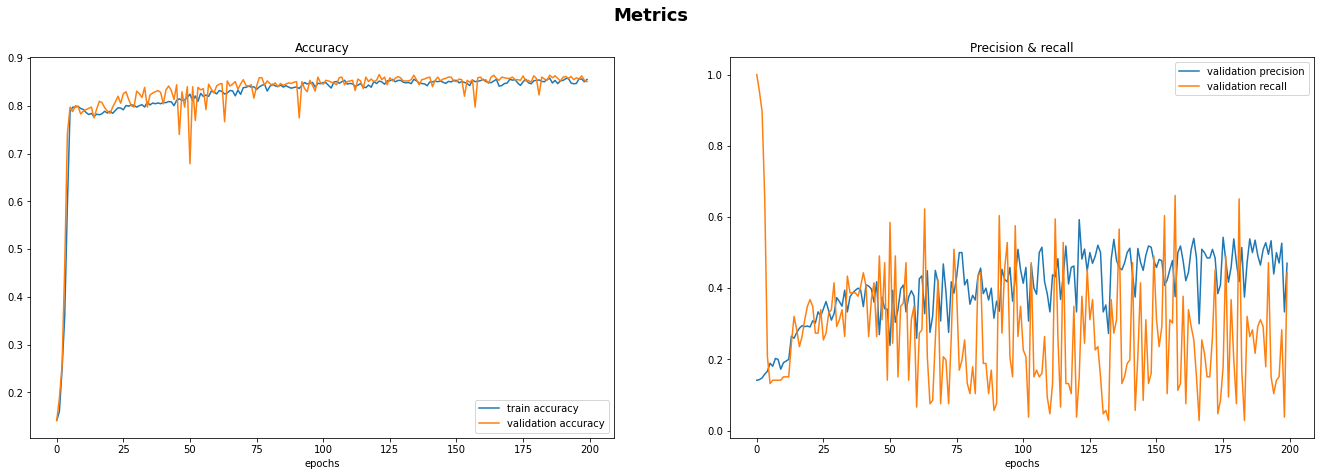

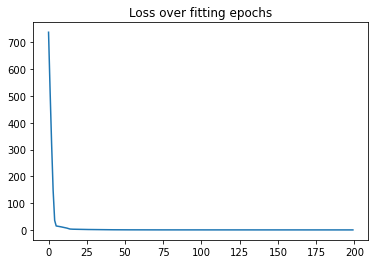

Min loss: 0.3875759243965149


In [11]:
plot_learning_curves(history_rec)
plot_learning_loss(history_rec)

In [12]:
y_pred = model_rec.predict(x_test)
#y_pred

In [13]:
import numpy as np

threshold = 0.5
y_pred = np.where(y_pred<=threshold, 0, 1)



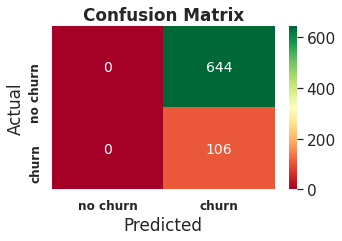


Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       644
           1       0.14      1.00      0.25       106

    accuracy                           0.14       750
   macro avg       0.07      0.50      0.12       750
weighted avg       0.02      0.14      0.04       750



/home/tobias/anaconda3/envs/tobias/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
print_classification_report(y_test, y_pred)

In [15]:
print_classification_report(y_test, y_pred)


Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       644
           1       0.14      1.00      0.25       106

    accuracy                           0.14       750
   macro avg       0.07      0.50      0.12       750
weighted avg       0.02      0.14      0.04       750



epochs = 20



model = Sequential()
model.add(Dense(64,kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(input_shape,), activation='relu' ))
model.add(Dropout(rate=0.4))
model.add(Dense(8,kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(1, activation='sigmoid'))
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay( 0.001,
      decay_steps=(x_train.shape[0]/32)*5,
      decay_rate=1,
      staircase=False)

#This time decay means for every 5 epochs the learning rate will be half of 0.001 value
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=70,restore_best_weights=True)]


model.compile(loss = "binary_crossentropy", 
                  optimizer = get_optimizer(), 
                  metrics=['accuracy'])
    

    
    
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=get_callbacks())#, verbose=0)

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

##  Model with best PRECISION

In [16]:
from tensorflow.keras.optimizers import Adam

optimizer= Adam(0.0001)

model_pre = build_model(input_shape=20, hidden_shapes=[32], hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')

model_pre.summary()

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [17]:
epo = 200

CB_checkpoint = ModelCheckpoint(monitor='val_precision', filepath='precision_model.hdf5', save_best_only=True, mode='max',verbose=0)


history_pre = model_pre.fit(x_train, y_train, epochs=epo, validation_data=(x_val, y_val), callbacks=[CB_checkpoint], verbose=0)

In [18]:
# Load best recall modell
model_pre.load_weights('precision_model.hdf5')

model_pre.evaluate(x_test, y_test)

24/24 [==============================] - 0s 1ms/step - loss: 0.4705 - accuracy: 0.8667 - precision: 0.5882 - recall: 0.1887


[0.47047343850135803,
 0.8666666746139526,
 0.5882353186607361,
 0.18867924809455872]

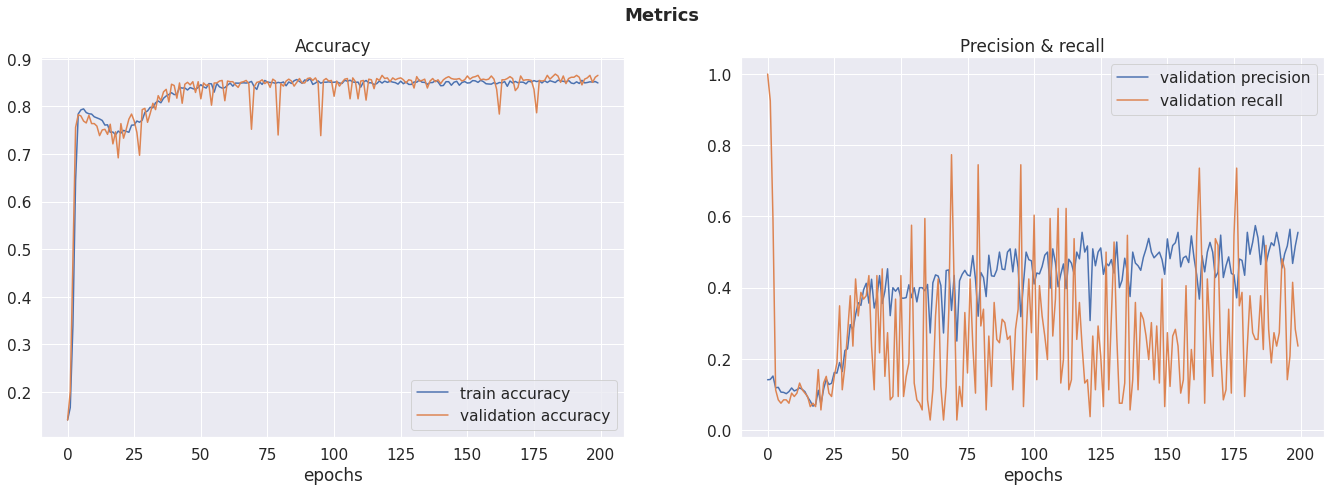

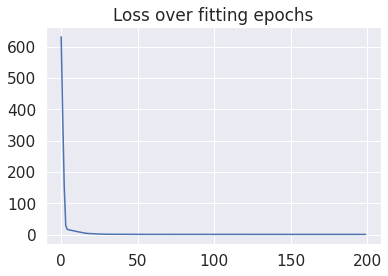

Min loss: 0.3794320821762085


In [19]:
plot_learning_curves(history_pre)
plot_learning_loss(history_pre)

In [20]:
y_pred = model_pre.predict(x_test)
#y_pred

In [21]:
threshold = 0.5
y_pred = np.where(y_pred<=threshold, 0, 1)

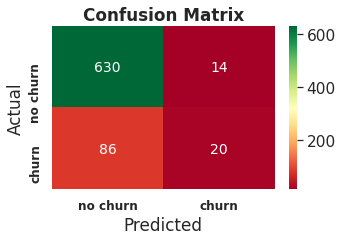


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750



In [22]:
plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
print_classification_report(y_test, y_pred)

# ONE hidden layer - hidden size tuning

In [23]:
from keras.models import load_model

 === Hidden layer size: 2 ===

Epoch 00001: val_recall improved from -inf to 0.00000, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall did not improve from 0.00000

Epoch 00003: val_recall did not improve from 0.00000

Epoch 00004: val_recall improved from 0.00000 to 0.00943, saving model to one_lay_rec_model.hdf5

Epoch 00005: val_recall improved from 0.00943 to 0.01887, saving model to one_lay_rec_model.hdf5

Epoch 00006: val_recall improved from 0.01887 to 0.06604, saving model to one_lay_rec_model.hdf5

Epoch 00007: val_recall improved from 0.06604 to 0.07547, saving model to one_lay_rec_model.hdf5

Epoch 00008: val_recall did not improve from 0.07547

Epoch 00009: val_recall improved from 0.07547 to 0.08491, saving model to one_lay_rec_model.hdf5

Epoch 00010: val_recall did not improve from 0.08491

Epoch 00011: val_recall did not improve from 0.08491

Epoch 00012: val_recall did not improve from 0.08491

Epoch 00013: val_recall did not improve from 0.08491

Epoch 

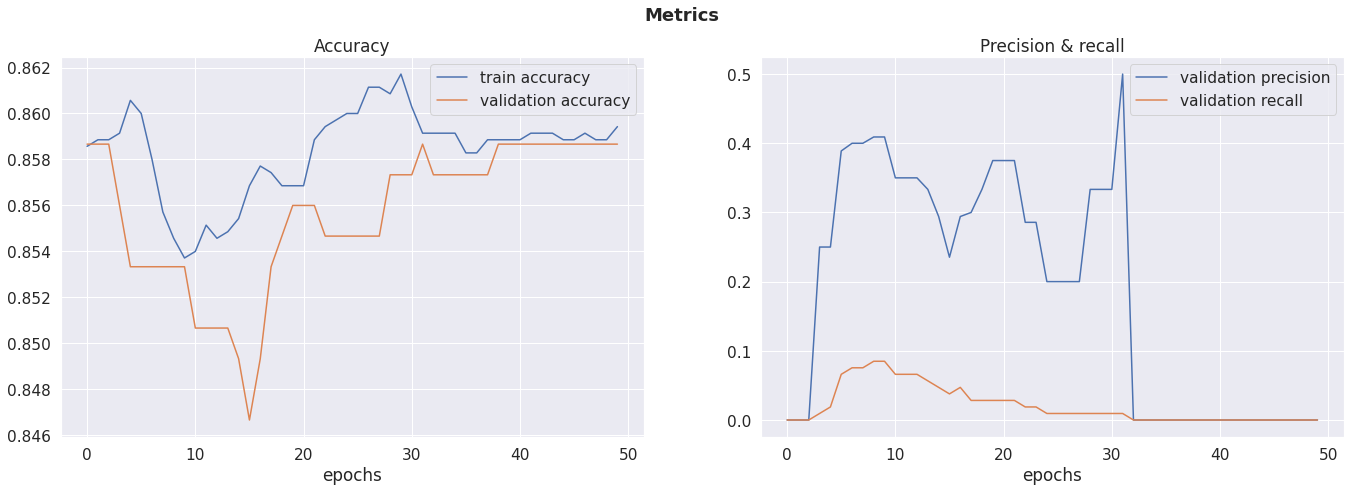

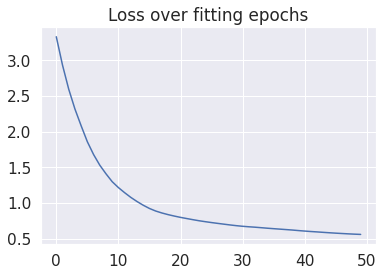

Min loss: 0.5606322288513184


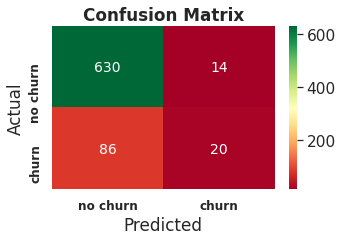


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 4 ===

Epoch 00001: val_recall improved from -inf to 0.70755, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall did not improve from 0.70755

Epoch 00003: val_recall did not improve from 0.70755

Epoch 00004: val_recall did not improve from 0.70755

Epoch 00005: val_recall did not improve from 0.70755

Epoch 00006: val_recall did not improve from 0.70755

Epoch 00007: val_recall did not improve from 0.70755

Epoch 00008: val_recall did not improve from 0.70755

Epoch 00009: val_recall did not improve from 0.70755

Epoch 00010: val_recall did not improve from 0.70755

Epoch 00011: val_recall did not impr

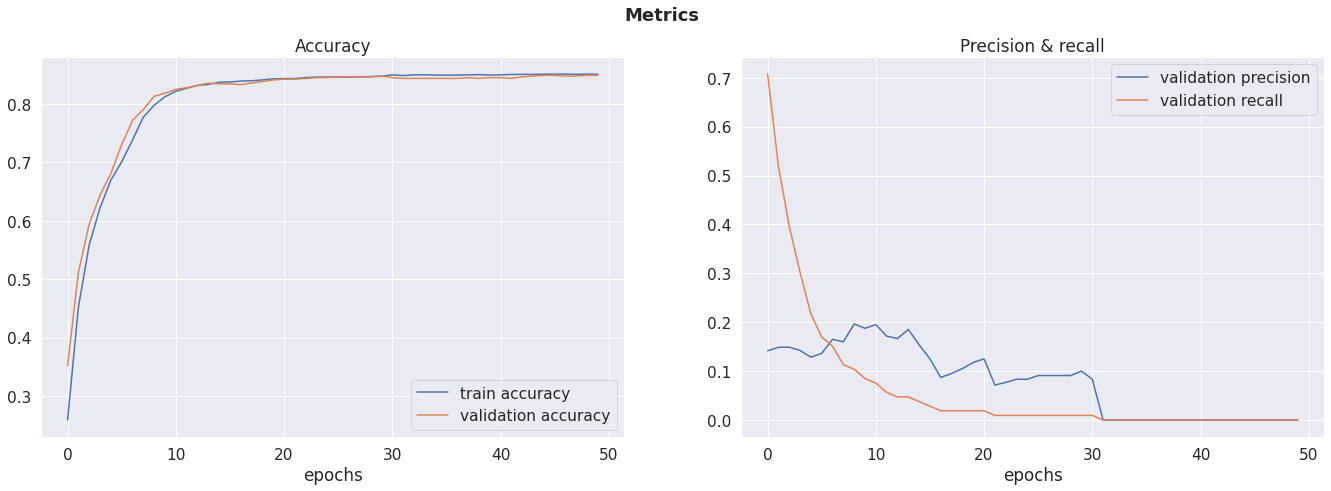

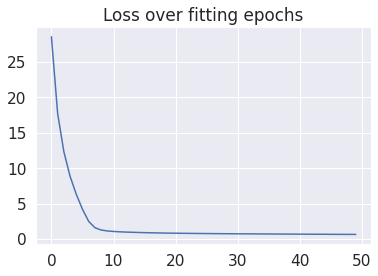

Min loss: 0.6400019526481628


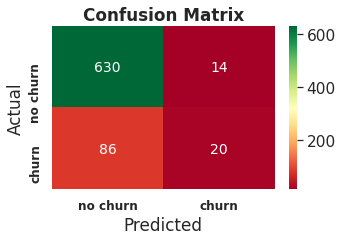


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 8 ===

Epoch 00001: val_recall improved from -inf to 0.00000, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall did not improve from 0.00000

Epoch 00003: val_recall did not improve from 0.00000

Epoch 00004: val_recall did not improve from 0.00000

Epoch 00005: val_recall did not improve from 0.00000

Epoch 00006: val_recall did not improve from 0.00000

Epoch 00007: val_recall improved from 0.00000 to 0.13208, saving model to one_lay_rec_model.hdf5

Epoch 00008: val_recall improved from 0.13208 to 0.19811, saving model to one_lay_rec_model.hdf5

Epoch 00009: val_recall improved from 0.19811 to 0.22642

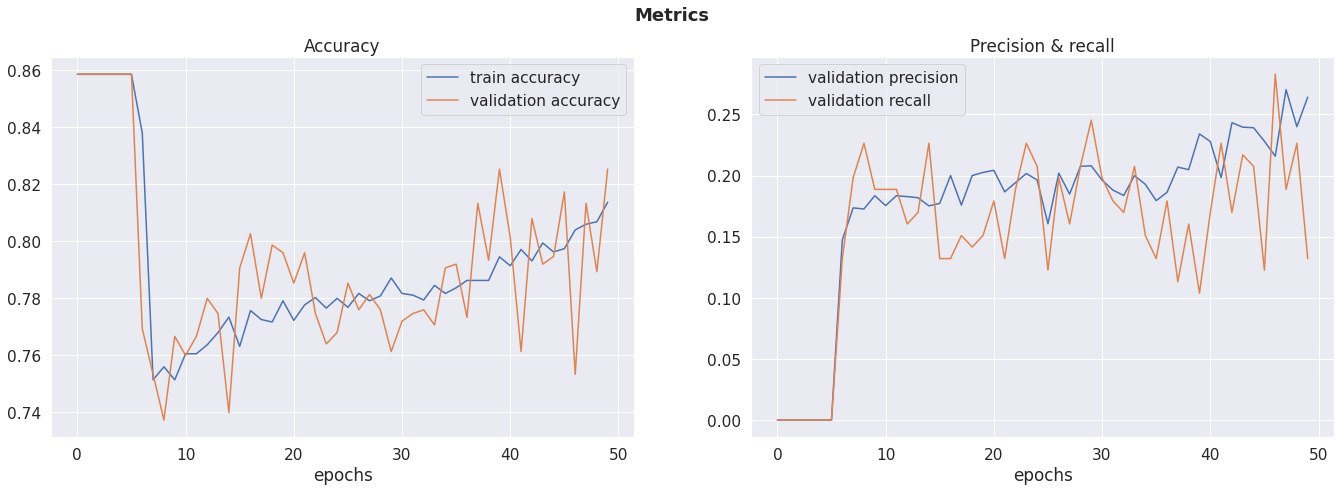

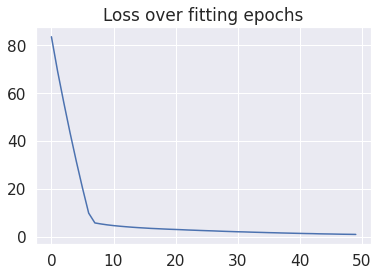

Min loss: 0.9657560586929321


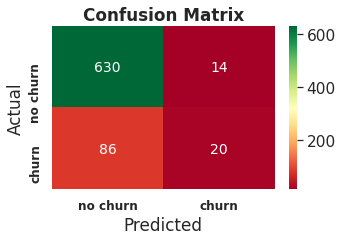


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 16 ===

Epoch 00001: val_recall improved from -inf to 0.24528, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall did not improve from 0.24528

Epoch 00003: val_recall improved from 0.24528 to 0.26415, saving model to one_lay_rec_model.hdf5

Epoch 00004: val_recall improved from 0.26415 to 0.29245, saving model to one_lay_rec_model.hdf5

Epoch 00005: val_recall did not improve from 0.29245

Epoch 00006: val_recall did not improve from 0.29245

Epoch 00007: val_recall did not improve from 0.29245

Epoch 00008: val_recall did not improve from 0.29245

Epoch 00009: val_recall did not improve from 0.29245

E

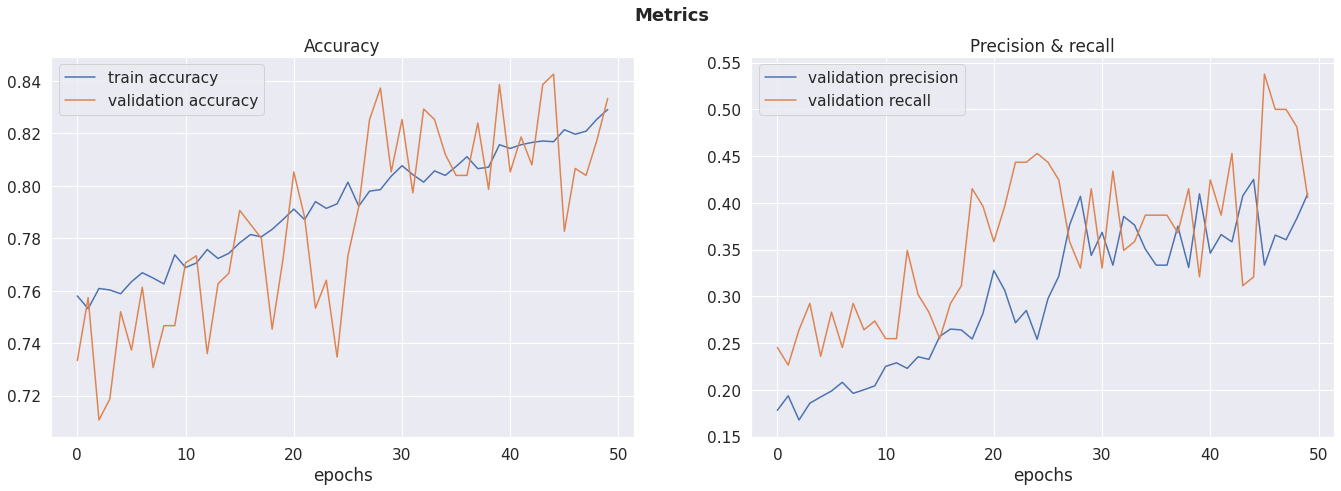

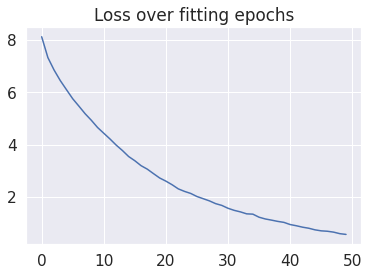

Min loss: 0.5683692693710327


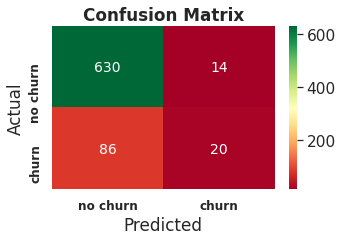


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 32 ===

Epoch 00001: val_recall improved from -inf to 0.98113, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall did not improve from 0.98113

Epoch 00003: val_recall did not improve from 0.98113

Epoch 00004: val_recall did not improve from 0.98113

Epoch 00005: val_recall did not improve from 0.98113

Epoch 00006: val_recall did not improve from 0.98113

Epoch 00007: val_recall did not improve from 0.98113

Epoch 00008: val_recall did not improve from 0.98113

Epoch 00009: val_recall did not improve from 0.98113

Epoch 00010: val_recall did not improve from 0.98113

Epoch 00011: val_recall did not imp

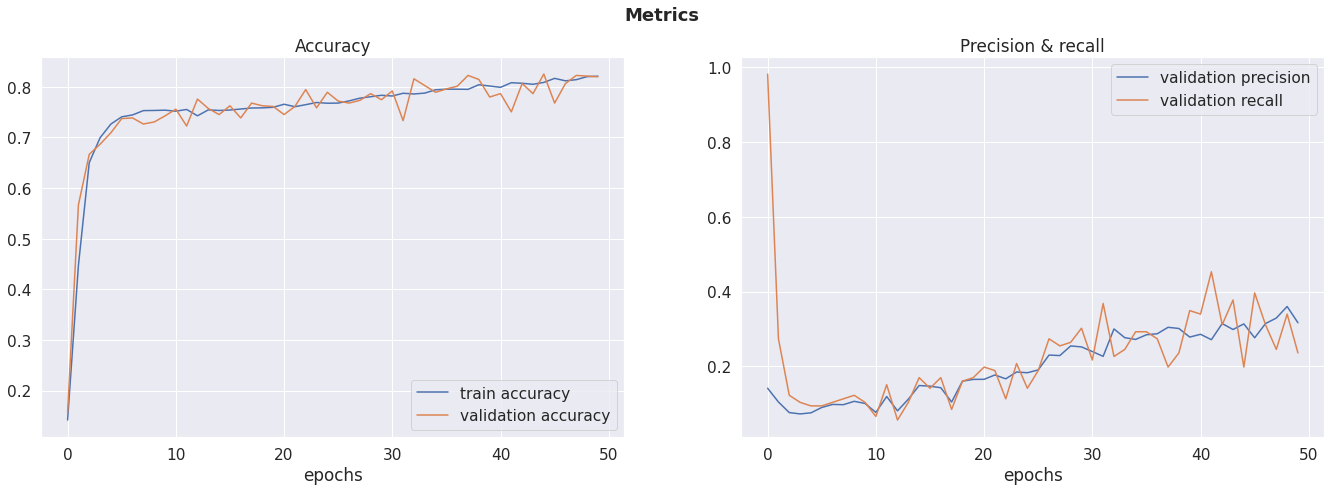

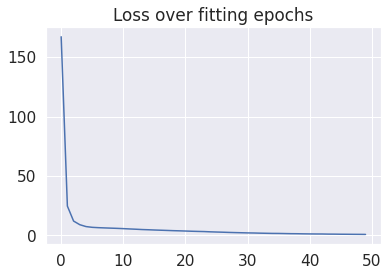

Min loss: 0.8336639404296875


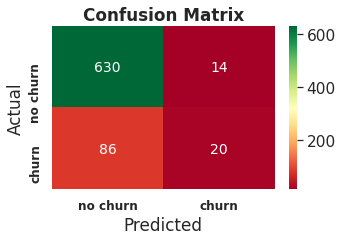


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 64 ===

Epoch 00001: val_recall improved from -inf to 0.03774, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall improved from 0.03774 to 0.18868, saving model to one_lay_rec_model.hdf5

Epoch 00003: val_recall did not improve from 0.18868

Epoch 00004: val_recall improved from 0.18868 to 0.21698, saving model to one_lay_rec_model.hdf5

Epoch 00005: val_recall improved from 0.21698 to 0.32075, saving model to one_lay_rec_model.hdf5

Epoch 00006: val_recall did not improve from 0.32075

Epoch 00007: val_recall did not improve from 0.32075

Epoch 00008: val_recall did not improve from 0.32075

Epoch 00009

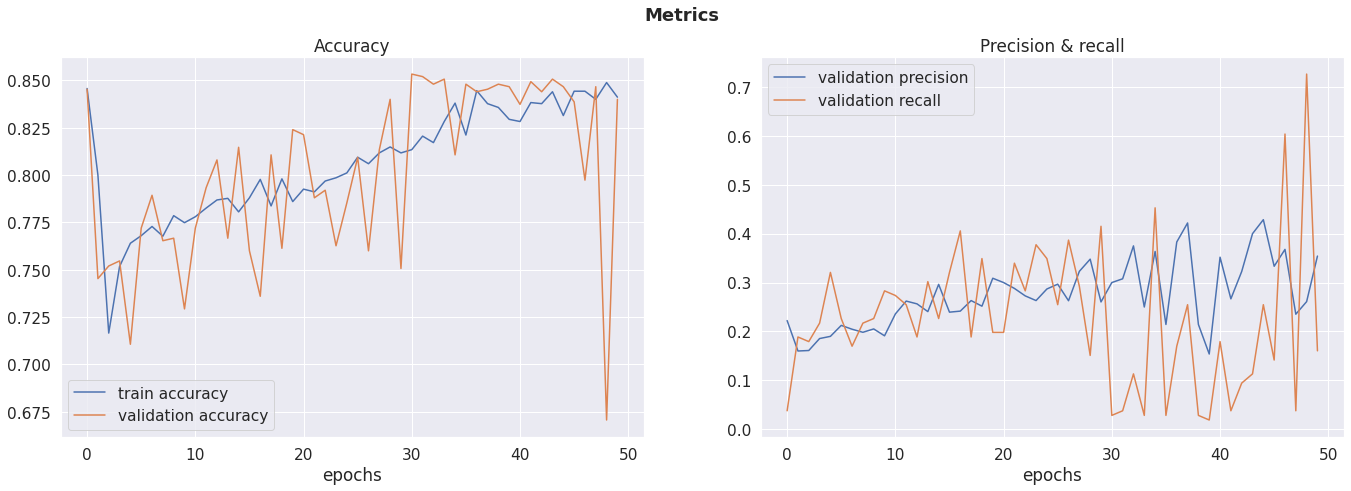

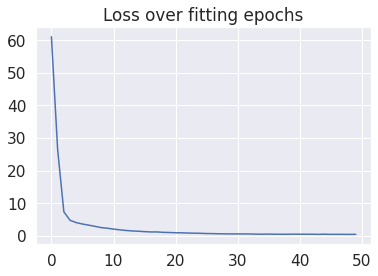

Min loss: 0.4571475088596344


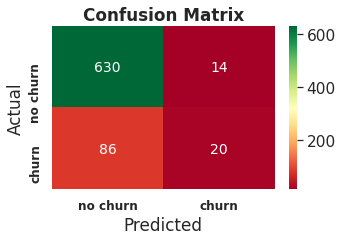


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 128 ===

Epoch 00001: val_recall improved from -inf to 0.80189, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall did not improve from 0.80189

Epoch 00003: val_recall did not improve from 0.80189

Epoch 00004: val_recall did not improve from 0.80189

Epoch 00005: val_recall did not improve from 0.80189

Epoch 00006: val_recall did not improve from 0.80189

Epoch 00007: val_recall did not improve from 0.80189

Epoch 00008: val_recall did not improve from 0.80189

Epoch 00009: val_recall did not improve from 0.80189

Epoch 00010: val_recall did not improve from 0.80189

Epoch 00011: val_recall did not im

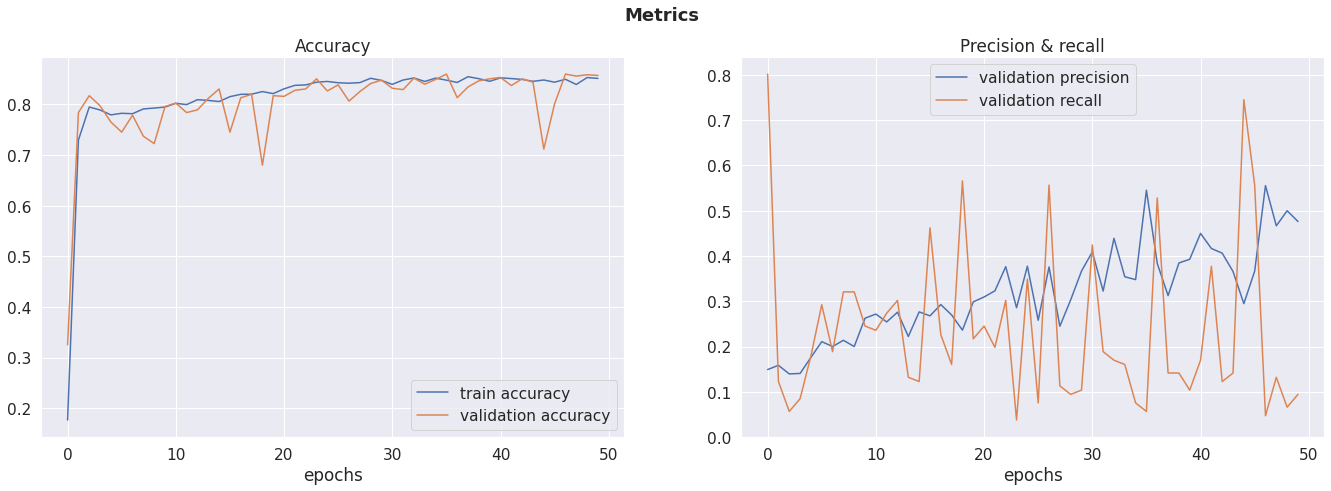

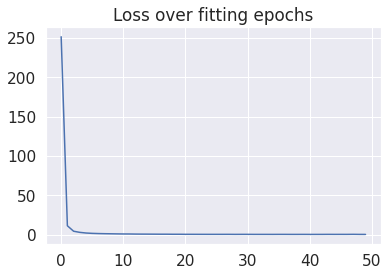

Min loss: 0.38995054364204407


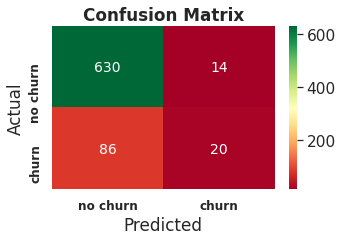


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 256 ===

Epoch 00001: val_recall improved from -inf to 0.09434, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall did not improve from 0.09434

Epoch 00003: val_recall did not improve from 0.09434

Epoch 00004: val_recall improved from 0.09434 to 0.36792, saving model to one_lay_rec_model.hdf5

Epoch 00005: val_recall did not improve from 0.36792

Epoch 00006: val_recall did not improve from 0.36792

Epoch 00007: val_recall did not improve from 0.36792

Epoch 00008: val_recall did not improve from 0.36792

Epoch 00009: val_recall did not improve from 0.36792

Epoch 00010: val_recall did not improve from

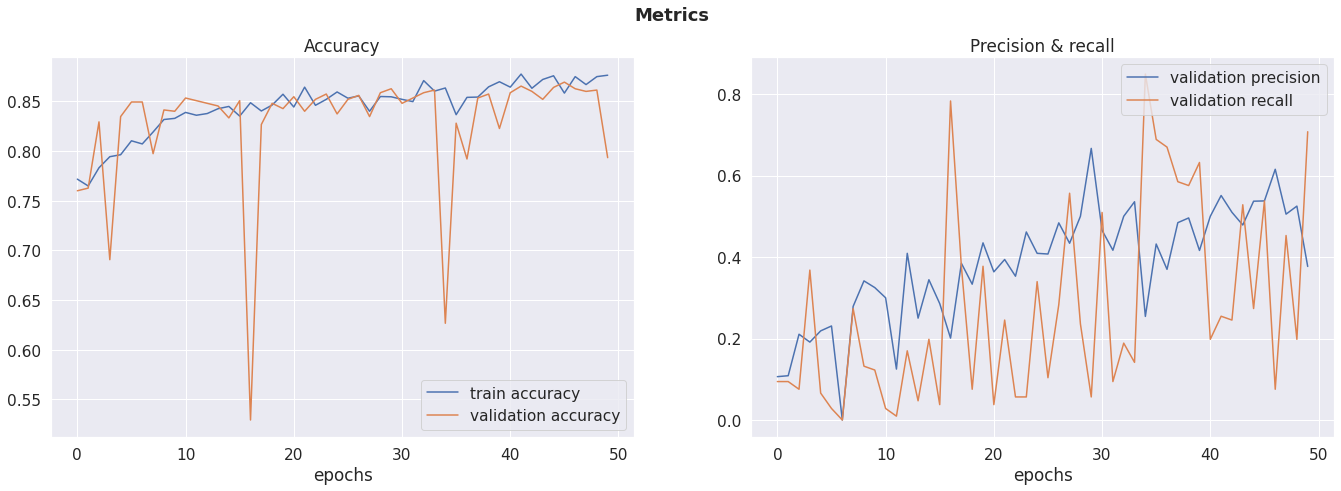

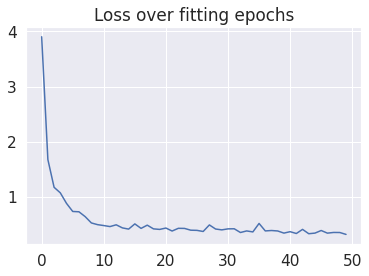

Min loss: 0.320899099111557


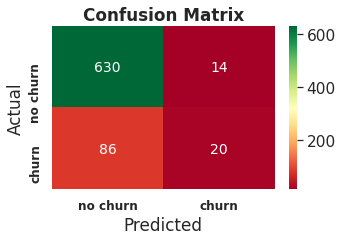


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 512 ===

Epoch 00001: val_recall improved from -inf to 0.33019, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall did not improve from 0.33019

Epoch 00003: val_recall improved from 0.33019 to 0.57547, saving model to one_lay_rec_model.hdf5

Epoch 00004: val_recall did not improve from 0.57547

Epoch 00005: val_recall did not improve from 0.57547

Epoch 00006: val_recall did not improve from 0.57547

Epoch 00007: val_recall improved from 0.57547 to 0.58491, saving model to one_lay_rec_model.hdf5

Epoch 00008: val_recall did not improve from 0.58491

Epoch 00009: val_recall did not improve from 0.58491



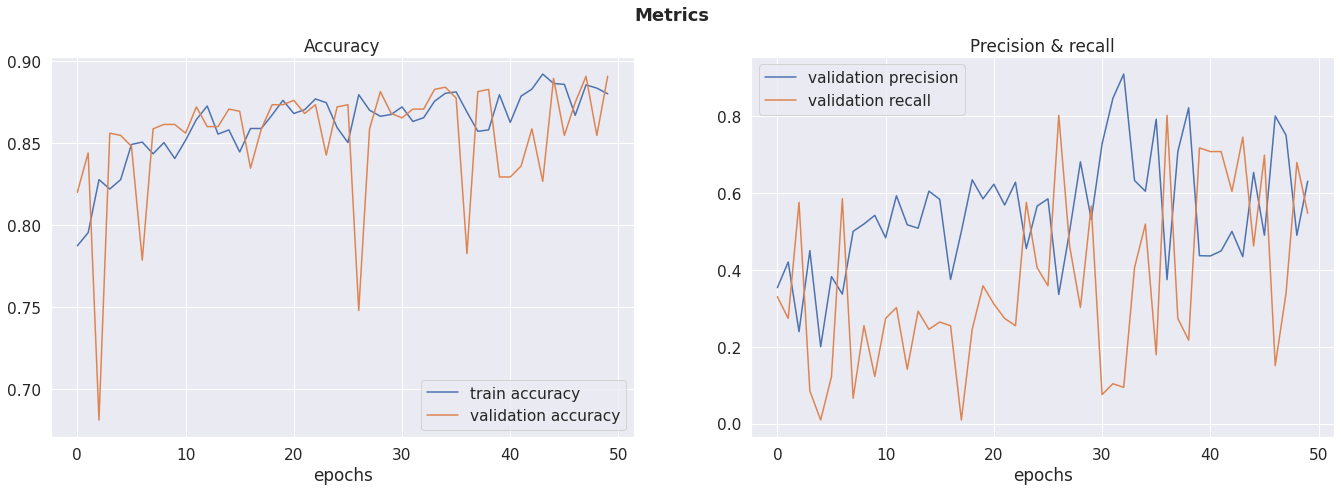

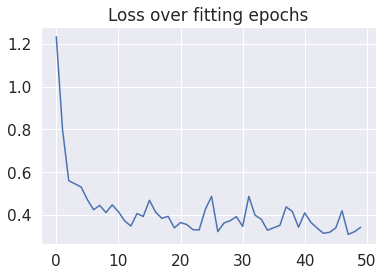

Min loss: 0.3091607987880707


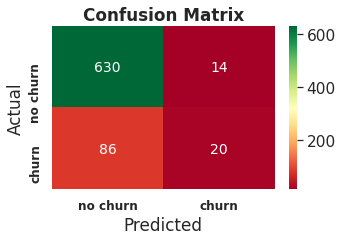


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 1024 ===

Epoch 00001: val_recall improved from -inf to 0.41509, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall did not improve from 0.41509

Epoch 00003: val_recall did not improve from 0.41509

Epoch 00004: val_recall did not improve from 0.41509

Epoch 00005: val_recall did not improve from 0.41509

Epoch 00006: val_recall did not improve from 0.41509

Epoch 00007: val_recall did not improve from 0.41509

Epoch 00008: val_recall did not improve from 0.41509

Epoch 00009: val_recall improved from 0.41509 to 0.62264, saving model to one_lay_rec_model.hdf5

Epoch 00010: val_recall did not improve fro

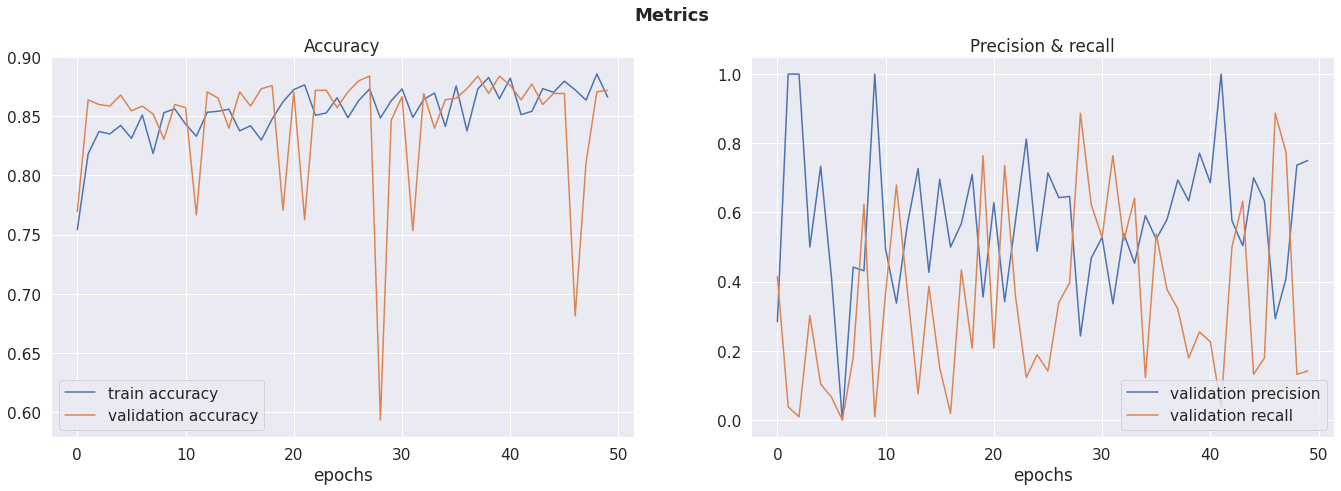

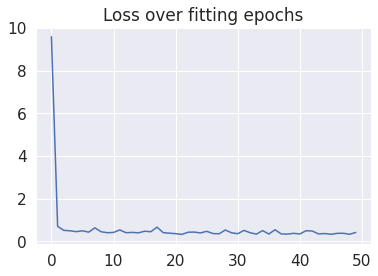

Min loss: 0.3256915807723999


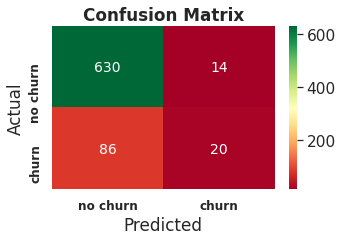


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 2048 ===

Epoch 00001: val_recall improved from -inf to 0.03774, saving model to one_lay_rec_model.hdf5

Epoch 00002: val_recall improved from 0.03774 to 0.68868, saving model to one_lay_rec_model.hdf5

Epoch 00003: val_recall did not improve from 0.68868

Epoch 00004: val_recall did not improve from 0.68868

Epoch 00005: val_recall did not improve from 0.68868

Epoch 00006: val_recall did not improve from 0.68868

Epoch 00007: val_recall did not improve from 0.68868

Epoch 00008: val_recall did not improve from 0.68868

Epoch 00009: val_recall did not improve from 0.68868

Epoch 00010: val_recall did not improve fro

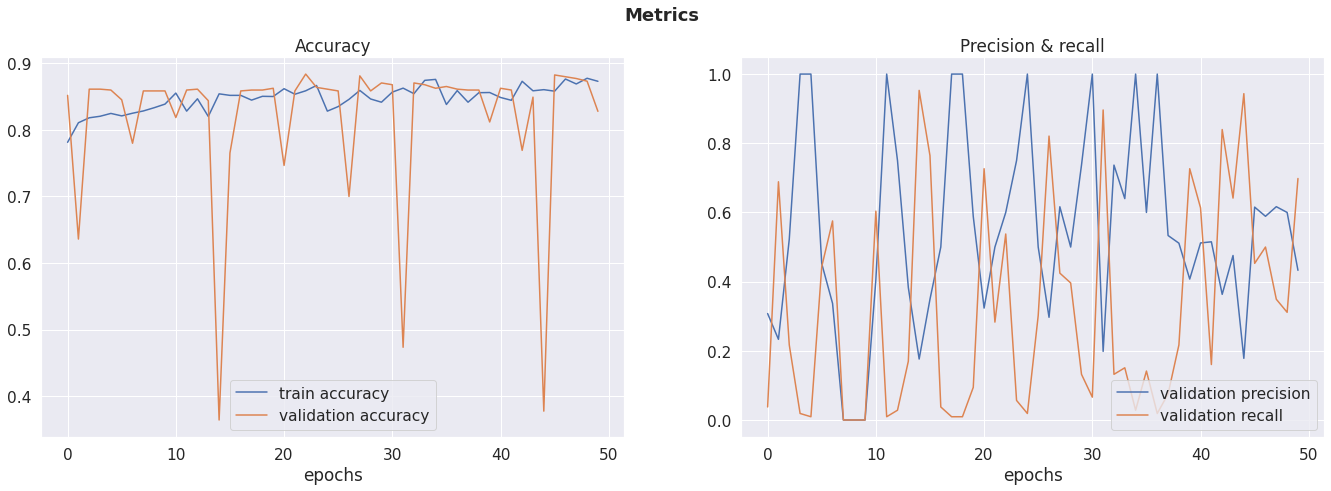

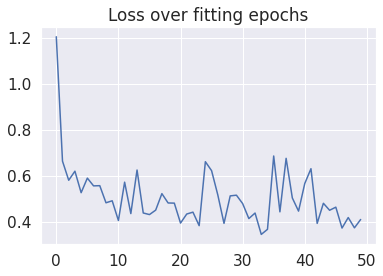

Min loss: 0.3444916605949402


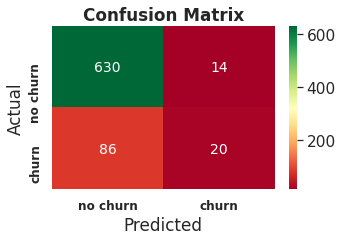


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750



In [24]:
epochs = 50

scores_hidden_dict = dict()

for hidden_shape in [2,4,8,16,32,64,128,256,512,1024,2048]:
    print(" === Hidden layer size:", hidden_shape, "===")

    scores = list()
    optimizer= Adam(0.0001)

    model_hidden = build_model(input_shape=20, hidden_shapes=[hidden_shape], hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')

    CB_checkpoint = ModelCheckpoint(monitor='val_recall', filepath='one_lay_rec_model.hdf5', save_best_only=True, mode='max', verbose=1)
    
    hist = model_hidden.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), verbose=0, callbacks=[CB_checkpoint])
    #scores_hidden_dict[hidden_shape] = hist.history['accuracy']
    
    #model_hidden.load_weights('one_lay_rec_model.hdf5')
    model_hidden = load_model('one_lay_rec_model.hdf5')

    
    y_pred = model_pre.predict(x_test)
    threshold = 0.5
    y_pred = np.where(y_pred<=threshold, 0, 1)
    
    plot_learning_curves(hist)
    plot_learning_loss(hist)
    
    plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
    print_classification_report(y_test, y_pred)
    del model_hidden

# Number of hidden layer tuning

In [25]:
# Number of hidden layers

from itertools import combinations_with_replacement, product
from random import sample

# initial set of layer size
x = [8, 16, 32, 64, 128]

# create combinations
c_2 = product(x, repeat=2) # 2 hidden layers
c_3 = product(x, repeat=3) # 3 hidden layers
c_4 = product(x, repeat=4) # 4 hidden layers
c_5 = product(x, repeat=5) # 5 hidden layers


# take 40 random combinations
c_2_sample = sample(list(c_2), 10)
c_3_sample = sample(list(c_3), 10)
c_4_sample = sample(list(c_4), 10)
c_5_sample = sample(list(c_5), 10)

test_comb = c_2_sample + c_3_sample + c_4_sample + c_5_sample

print(f" {len(test_comb)} test combinations chosen:\n{test_comb}")

 40 test combinations chosen:
[(64, 128), (16, 128), (32, 16), (16, 16), (8, 128), (8, 64), (64, 32), (128, 16), (32, 128), (64, 16), (64, 32, 64), (32, 32, 8), (128, 32, 64), (16, 64, 64), (8, 128, 16), (8, 64, 32), (8, 16, 64), (128, 8, 16), (32, 64, 64), (8, 64, 128), (8, 32, 16, 64), (64, 128, 8, 8), (128, 64, 16, 128), (32, 16, 64, 16), (8, 16, 16, 16), (16, 128, 16, 16), (8, 32, 32, 64), (64, 16, 128, 32), (16, 32, 64, 32), (8, 128, 32, 32), (8, 16, 64, 32, 128), (128, 64, 32, 128, 8), (64, 32, 32, 64, 16), (128, 8, 16, 128, 128), (32, 64, 16, 32, 32), (8, 64, 8, 8, 64), (8, 128, 128, 8, 64), (64, 64, 8, 64, 8), (128, 64, 64, 8, 16), (16, 16, 32, 16, 16)]


 === Hidden layer size: (64, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
_________________________________________________________________


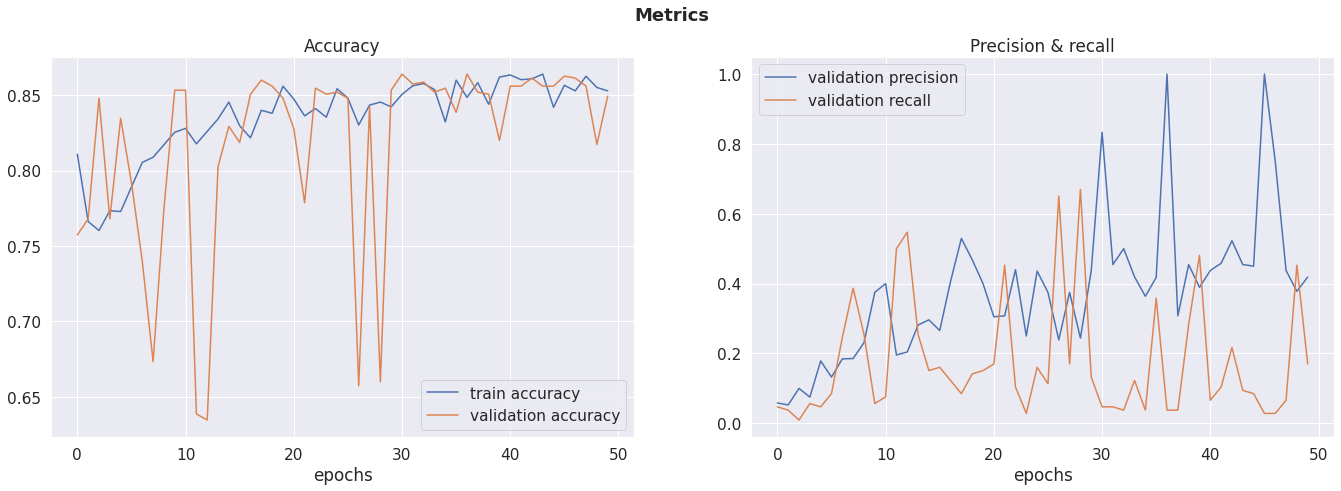

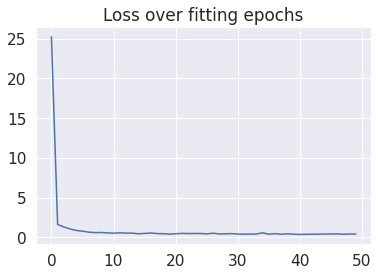

Min loss: 0.3776908814907074


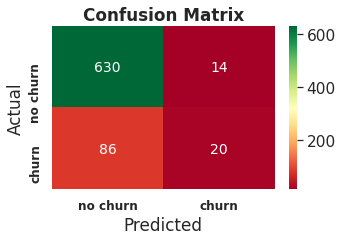


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               2176      
_________________________________________________________________
dense_1 (Dense)              (None, 1)           

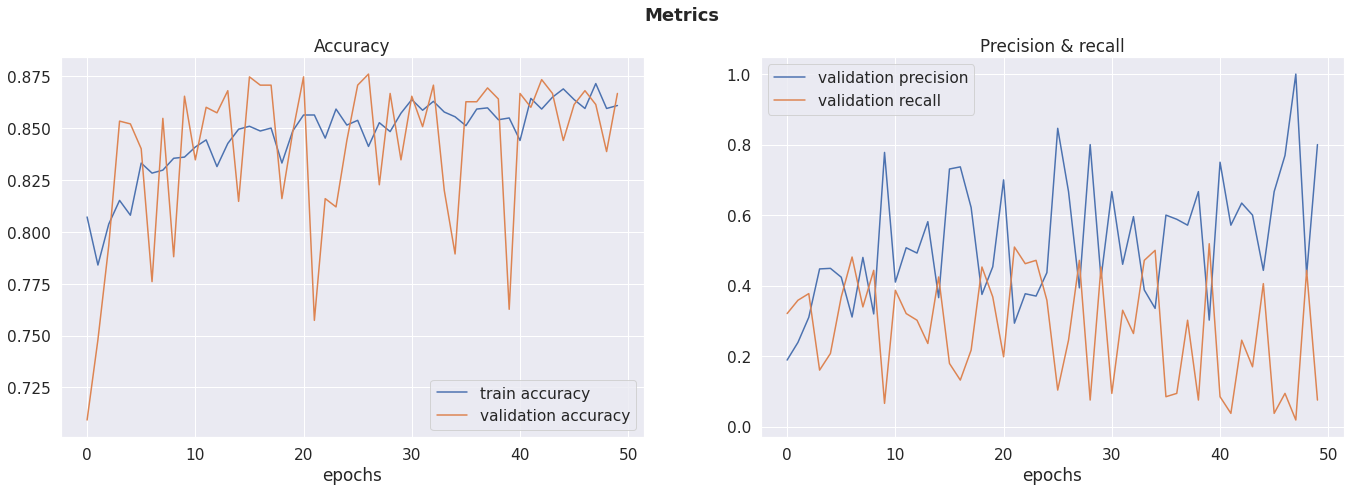

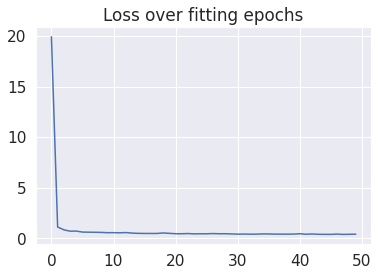

Min loss: 0.39156606793403625


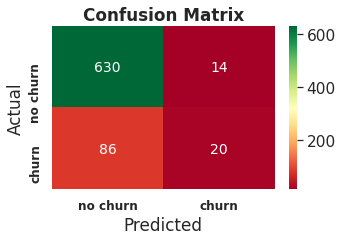


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)            

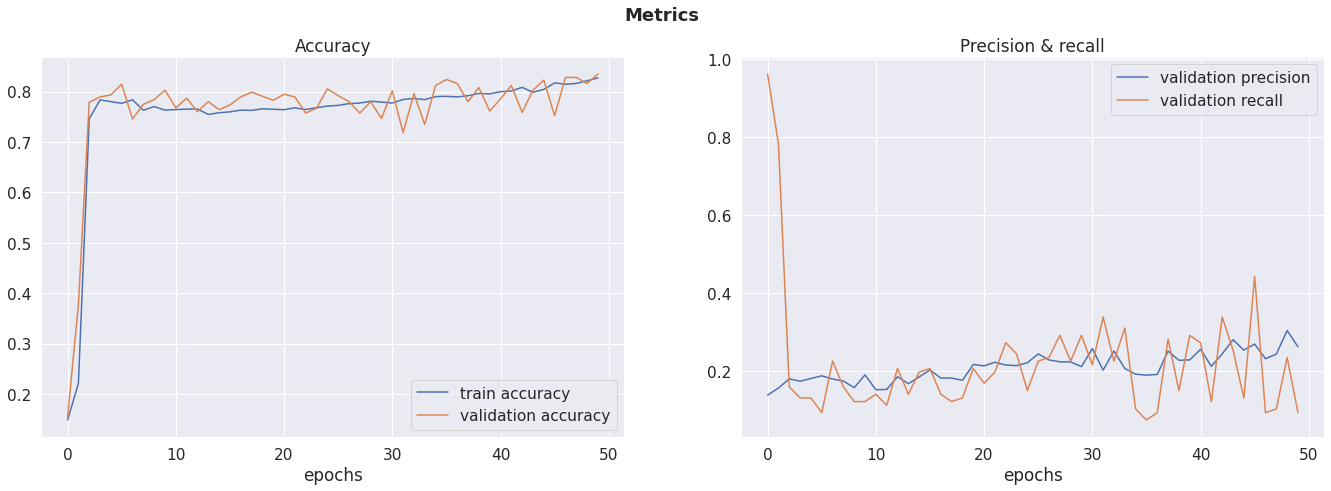

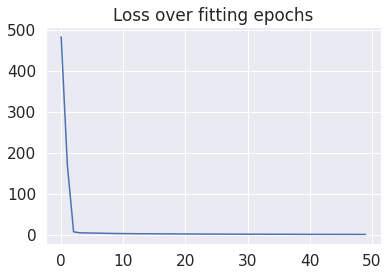

Min loss: 0.5303342342376709


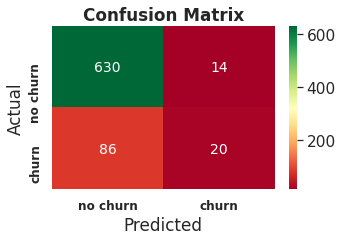


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)            

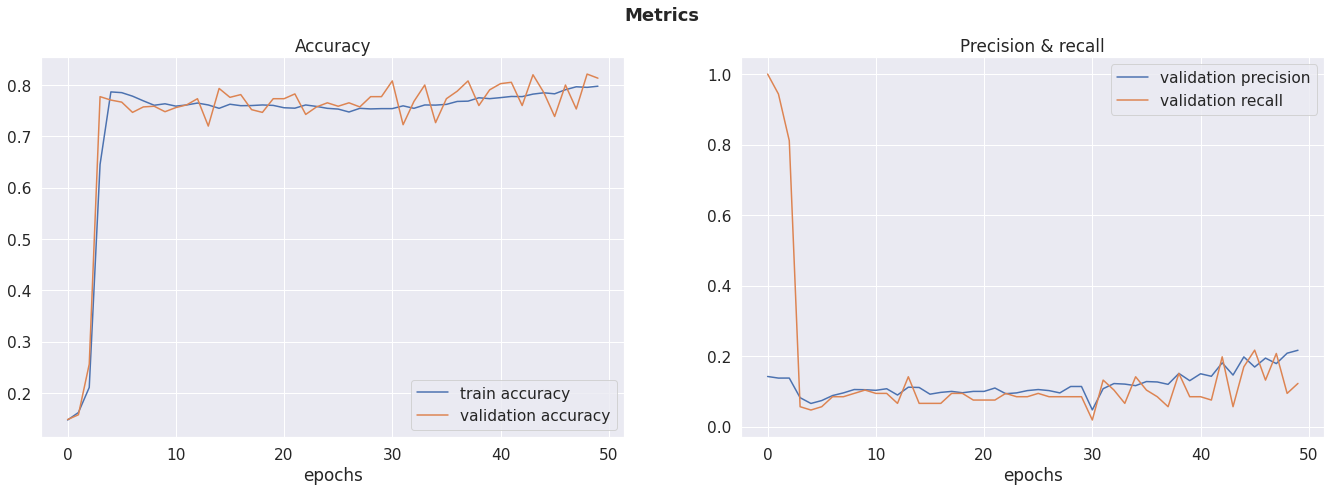

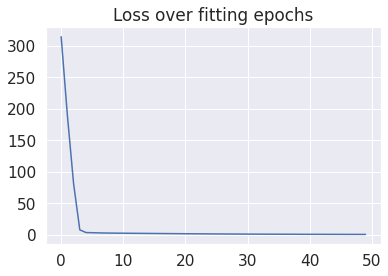

Min loss: 0.6290856003761292


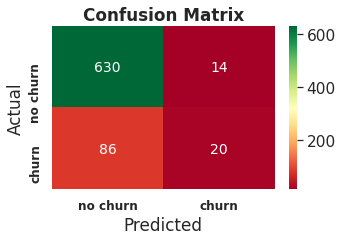


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 1)            

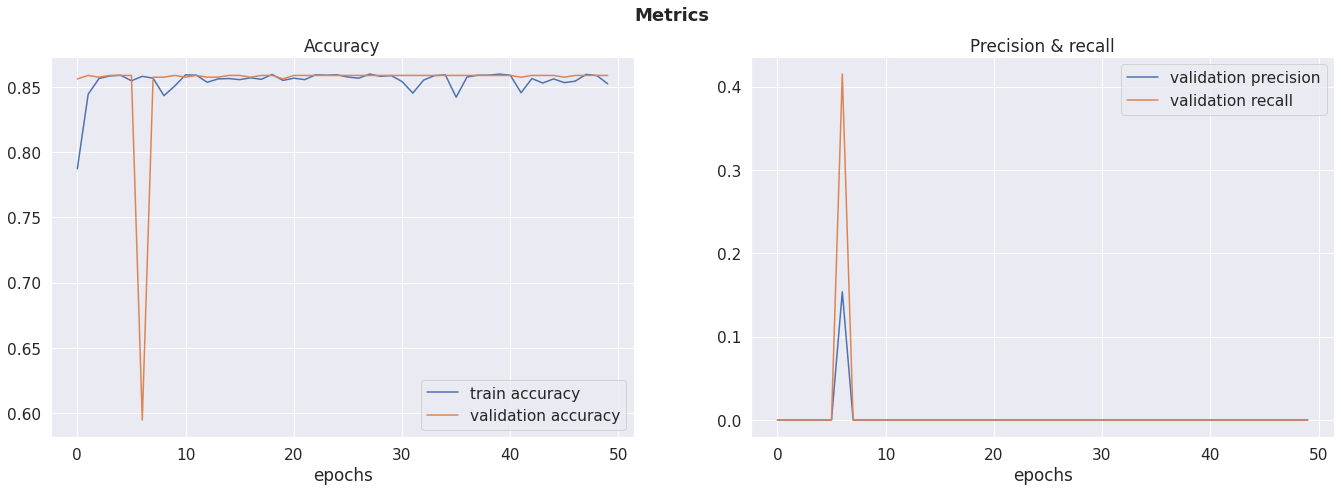

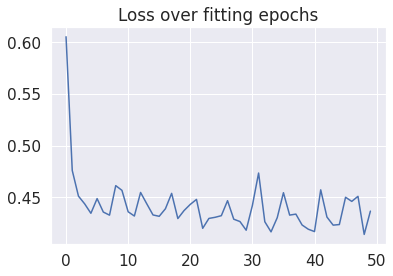

Min loss: 0.4139840602874756


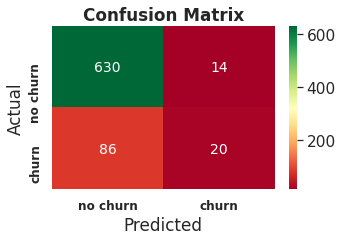


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 1)             

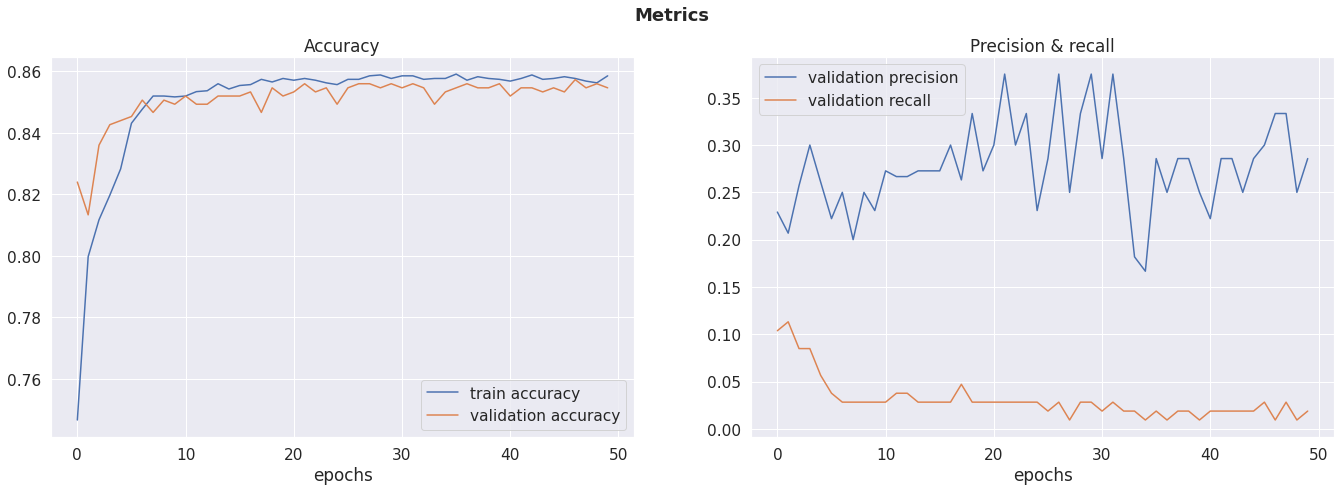

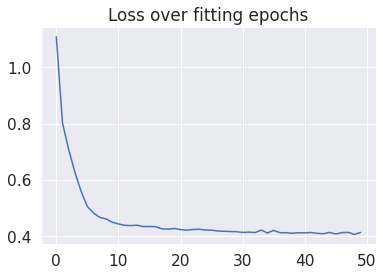

Min loss: 0.4062477946281433


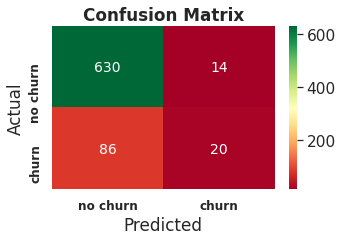


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)            

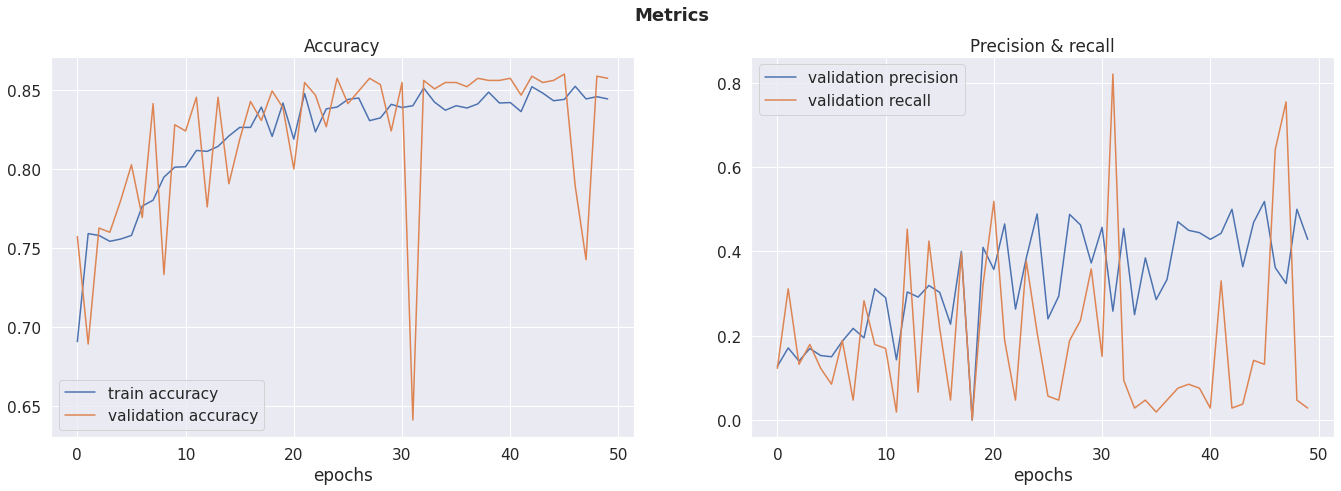

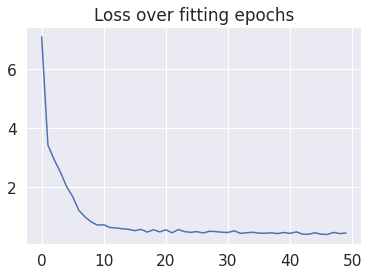

Min loss: 0.40682724118232727


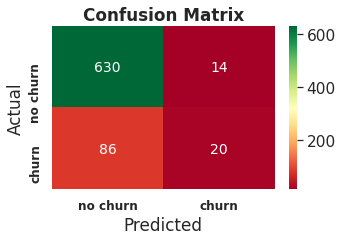


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)           

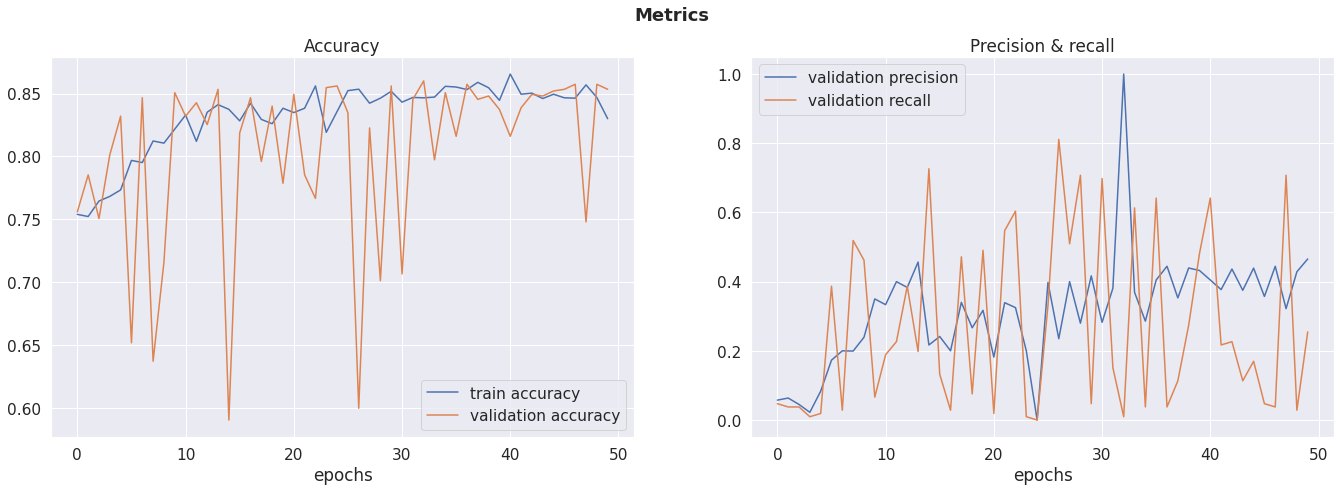

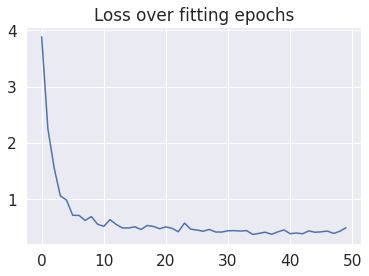

Min loss: 0.3774815797805786


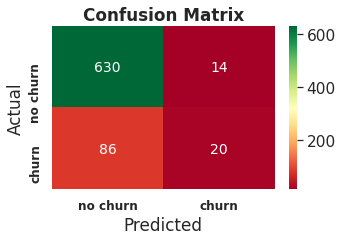


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)           

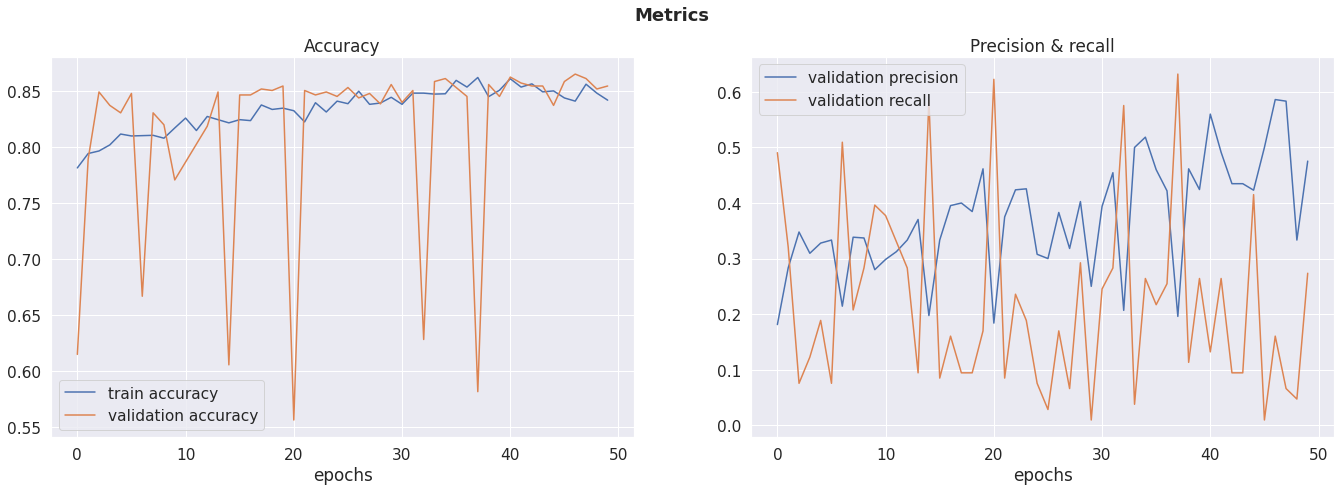

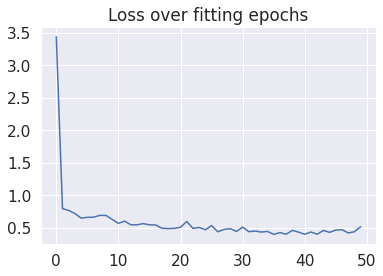

Min loss: 0.40254586935043335


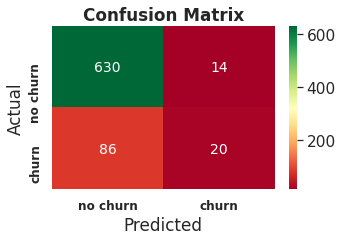


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)            

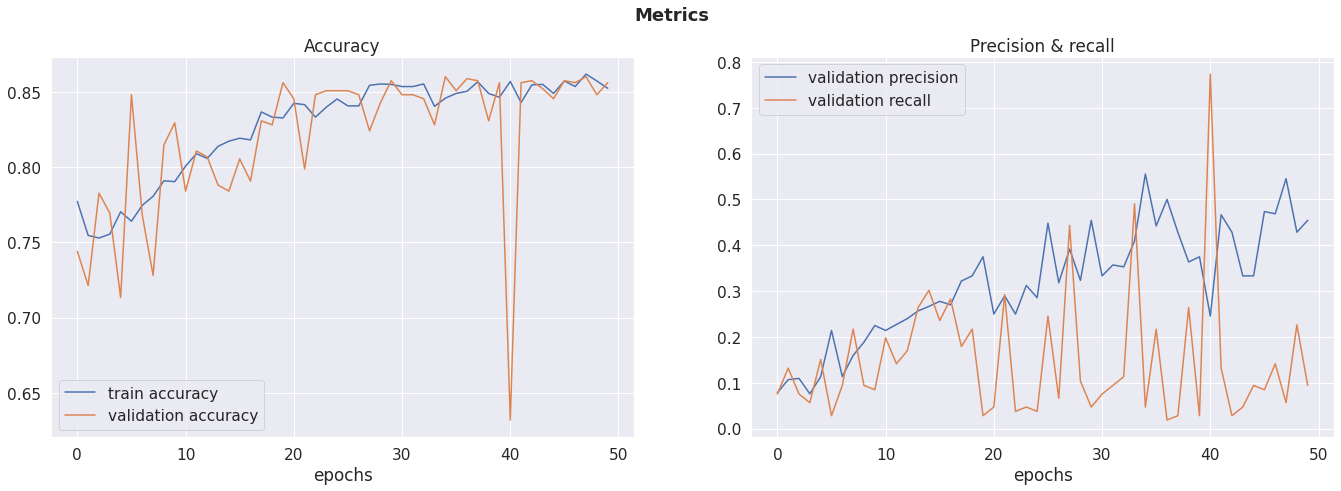

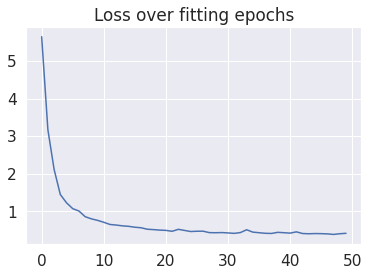

Min loss: 0.38464686274528503


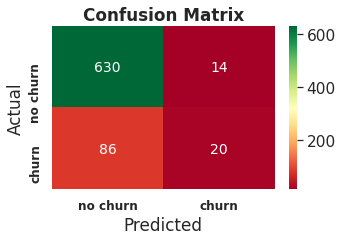


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 32, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                2080      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64)       

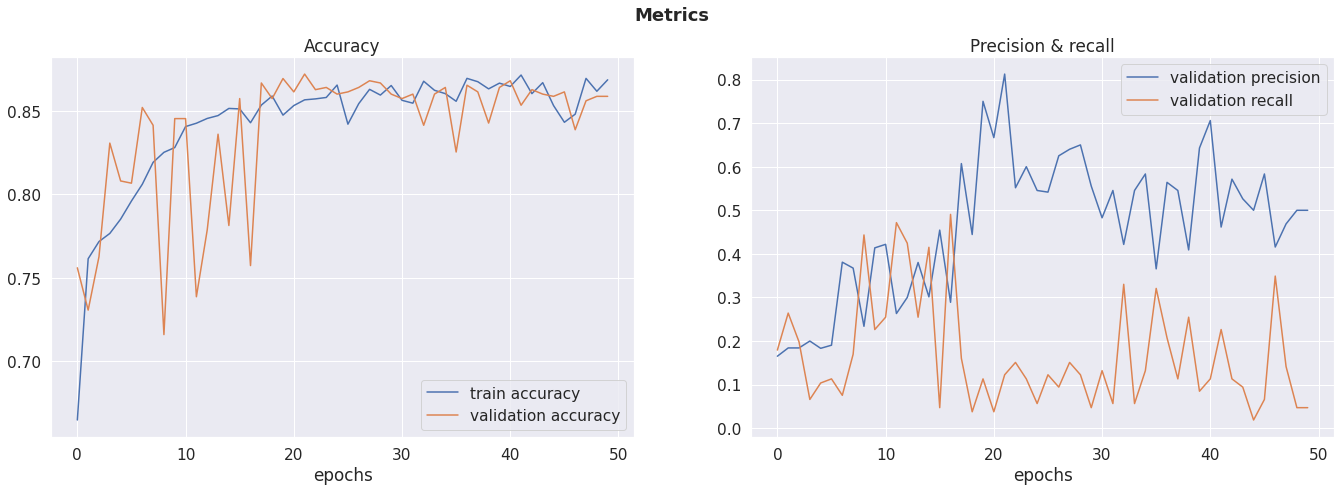

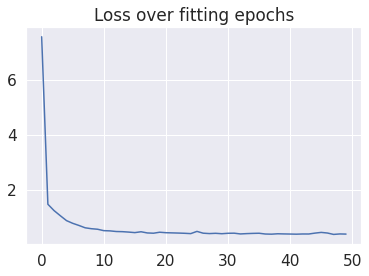

Min loss: 0.37096312642097473


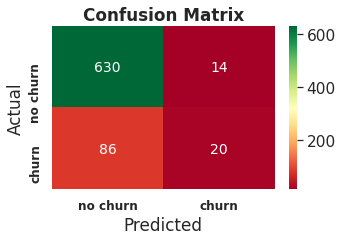


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 32, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                1056      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)         

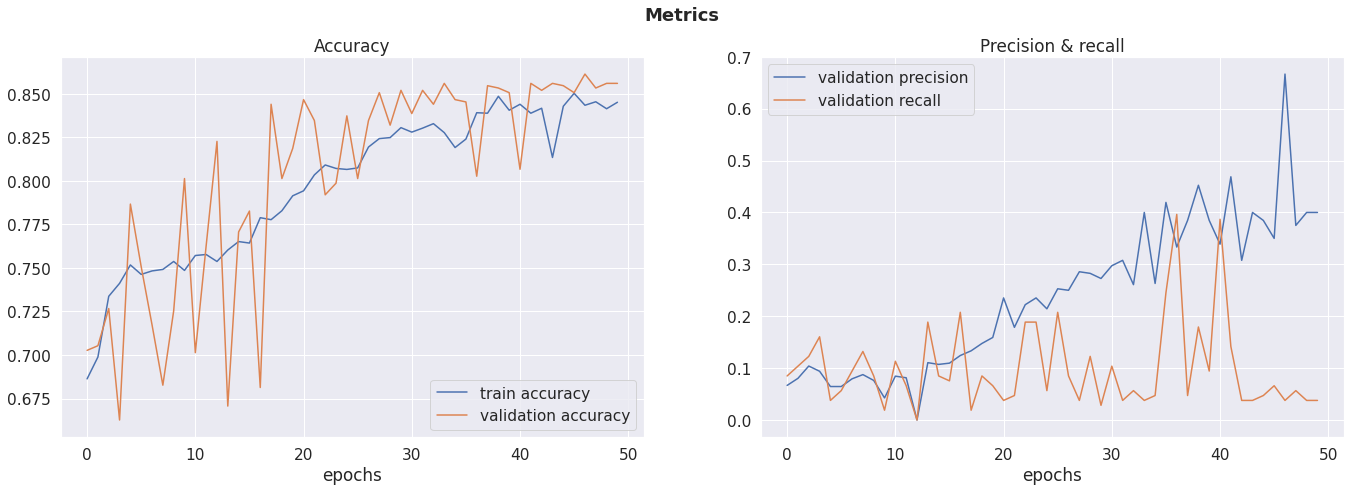

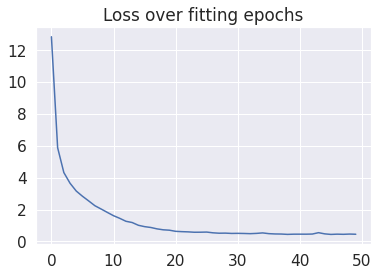

Min loss: 0.44193151593208313


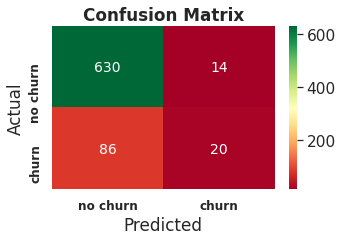


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 32, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                4128      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64)      

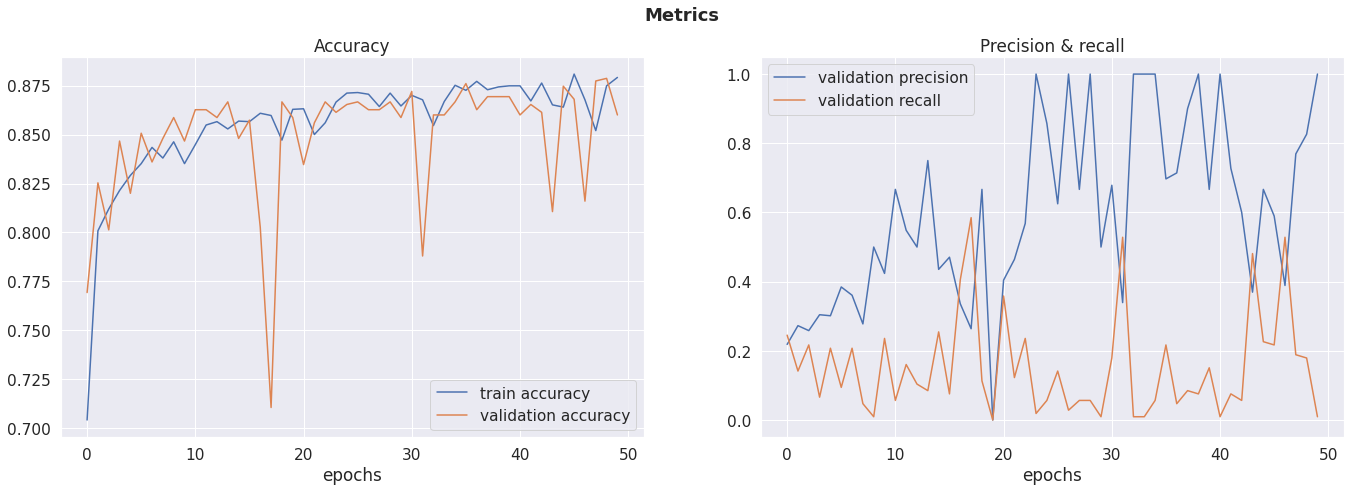

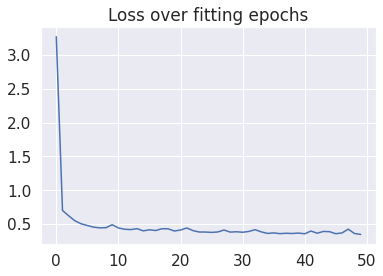

Min loss: 0.3452126085758209


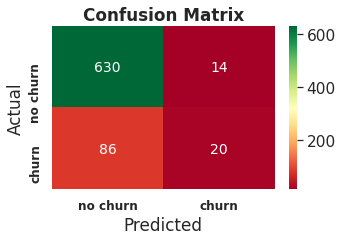


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 64, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                1088      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64)       

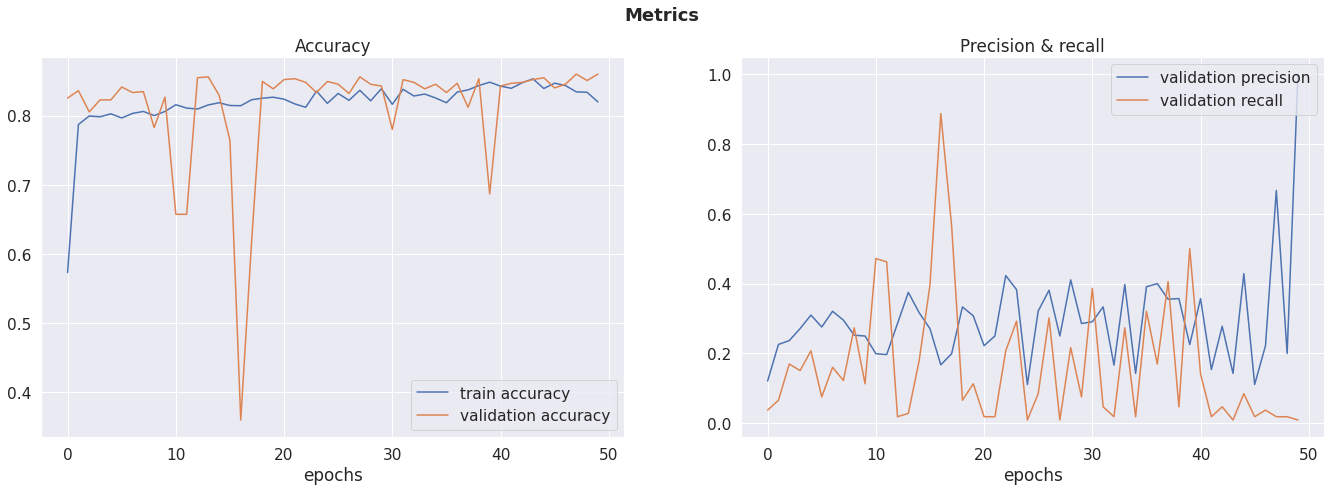

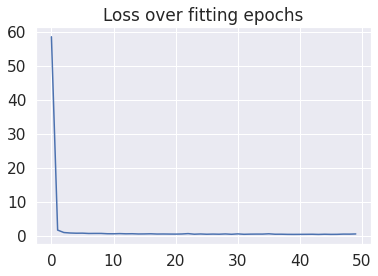

Min loss: 0.4311429560184479


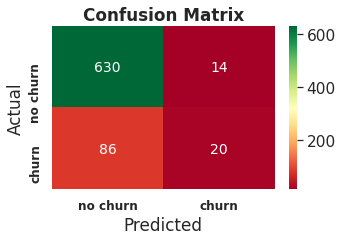


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 128, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               1152      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 16)       

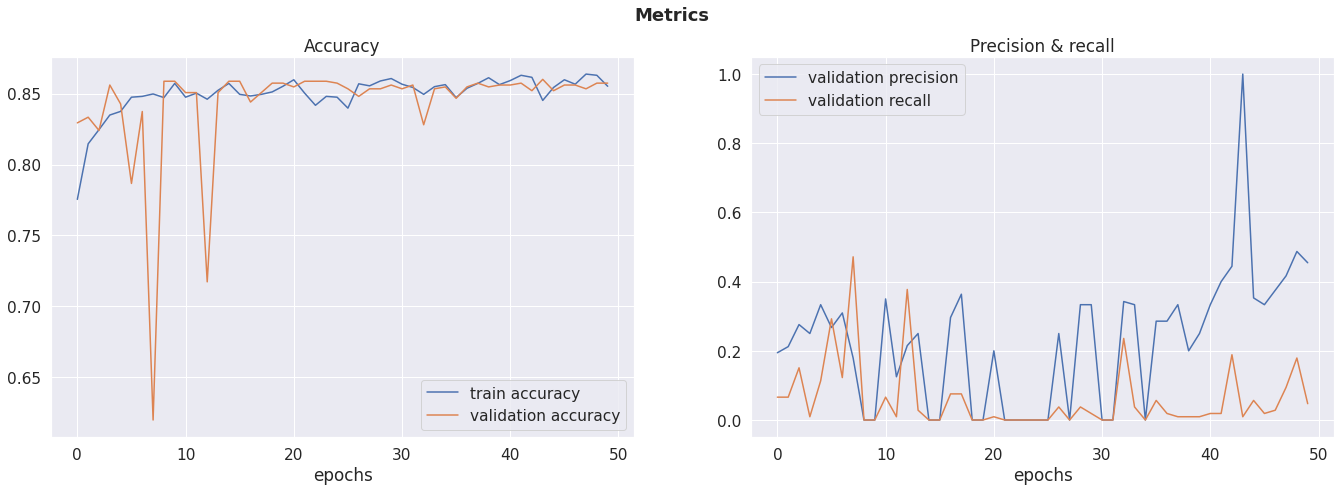

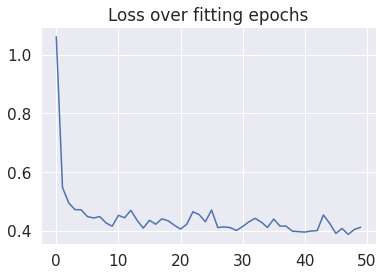

Min loss: 0.38871750235557556


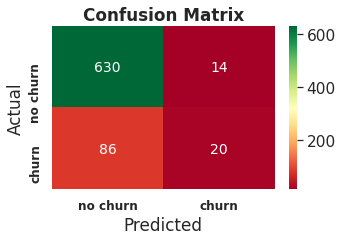


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 64, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                576       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 32)        

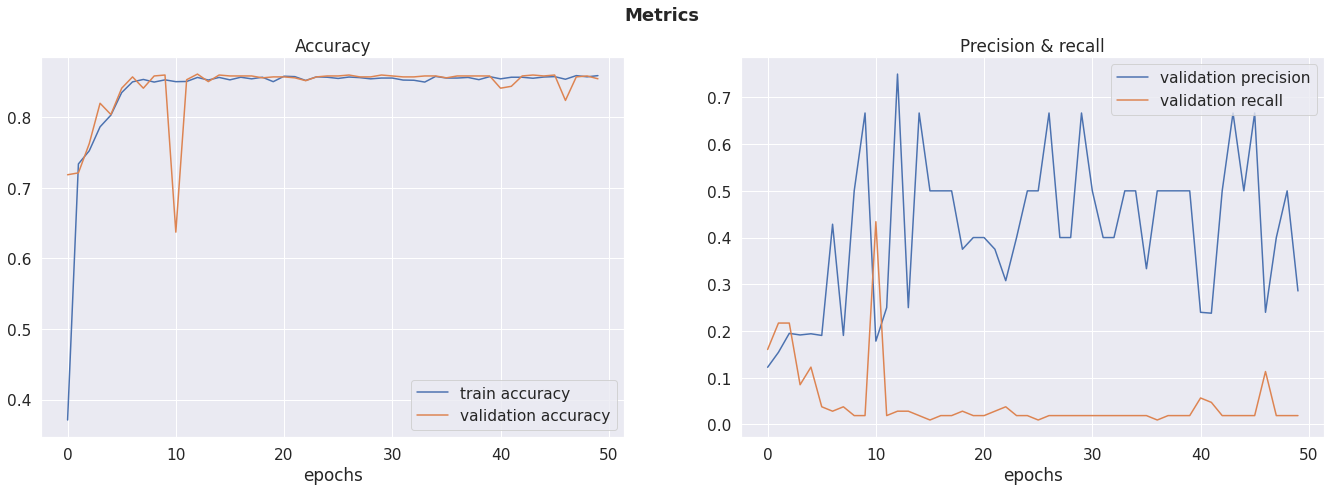

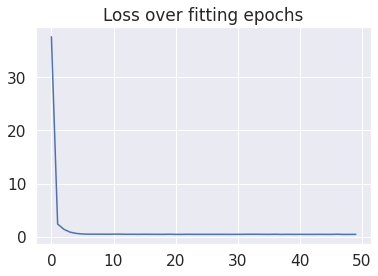

Min loss: 0.41385605931282043


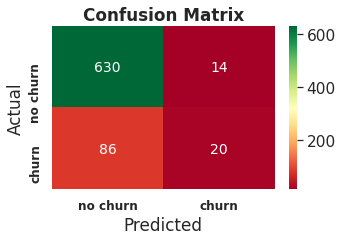


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 16, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                144       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64)        

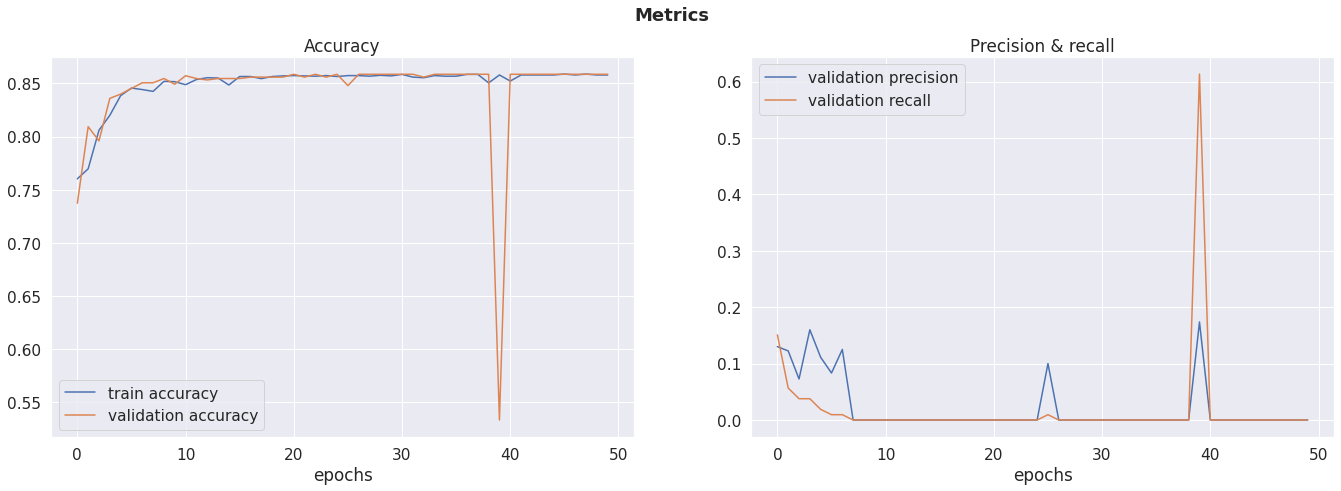

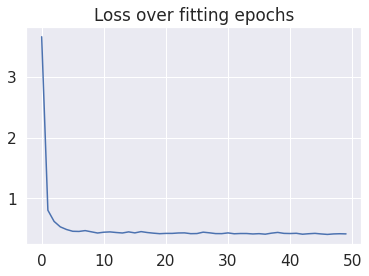

Min loss: 0.40864187479019165


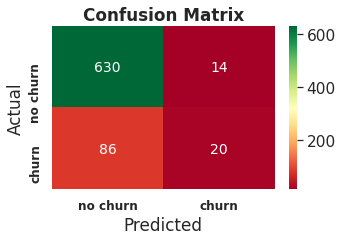


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 8, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 1032      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 16)       

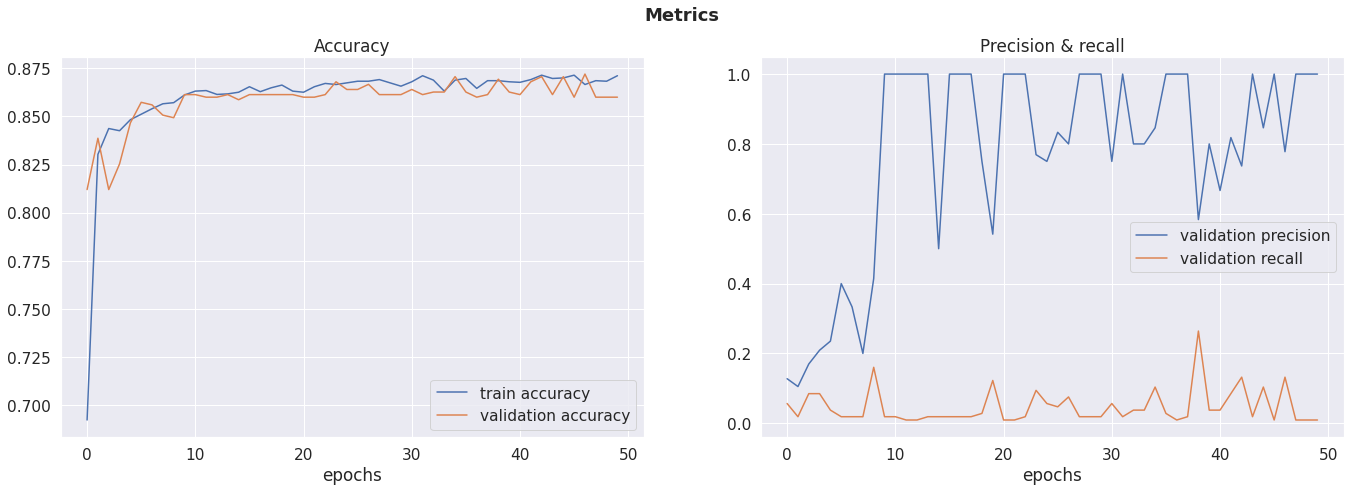

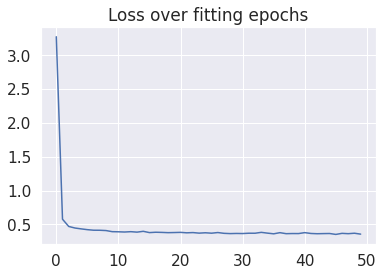

Min loss: 0.35338953137397766


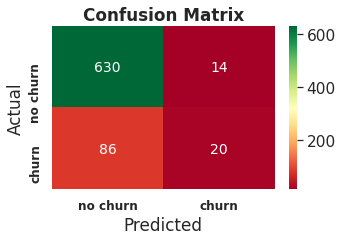


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 64, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                2112      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64)       

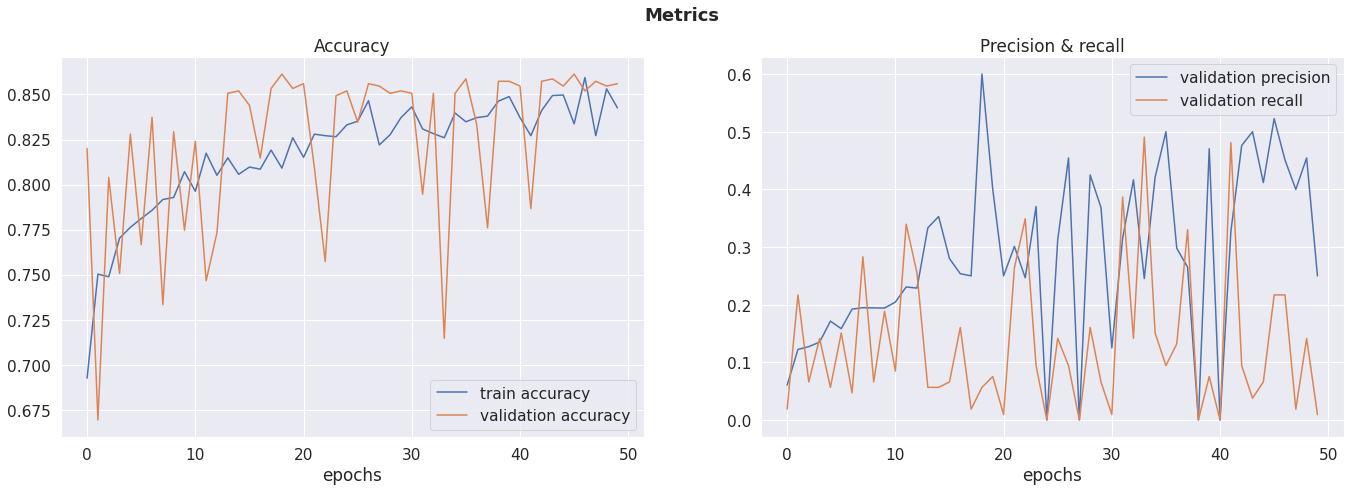

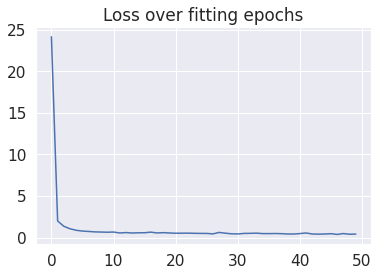

Min loss: 0.403214693069458


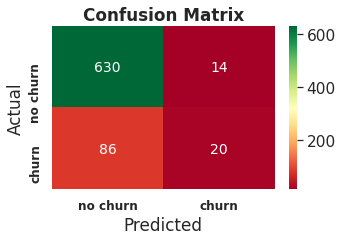


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 64, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                576       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 128)      

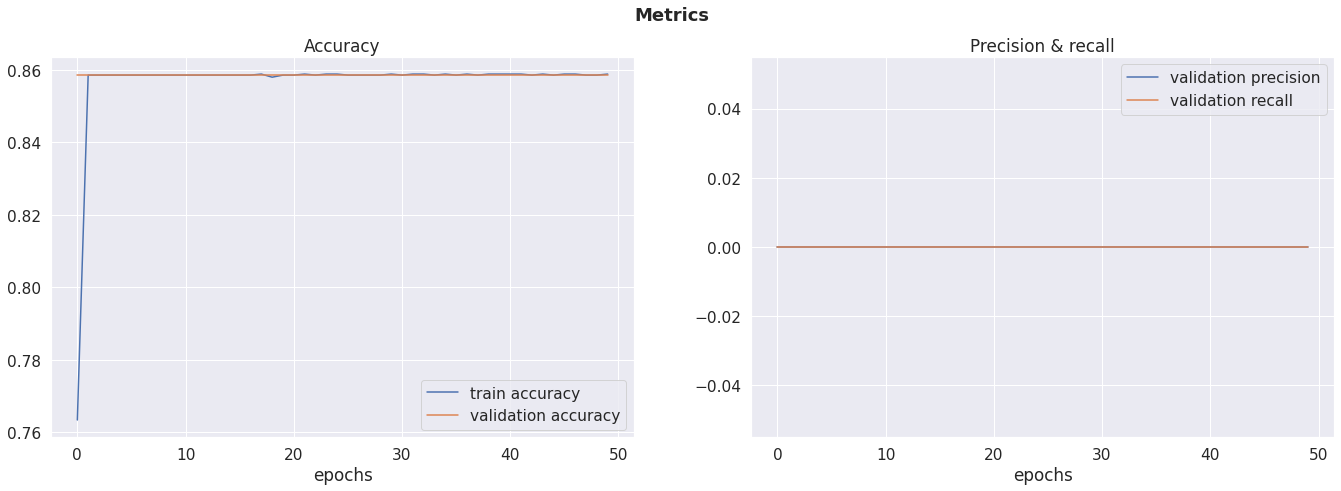

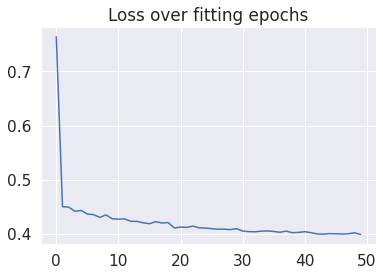

Min loss: 0.3985070586204529


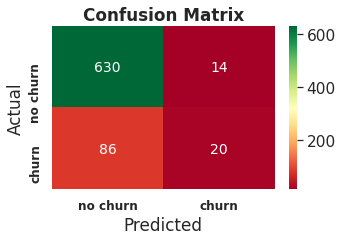


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 32, 16, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                288       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 16)    

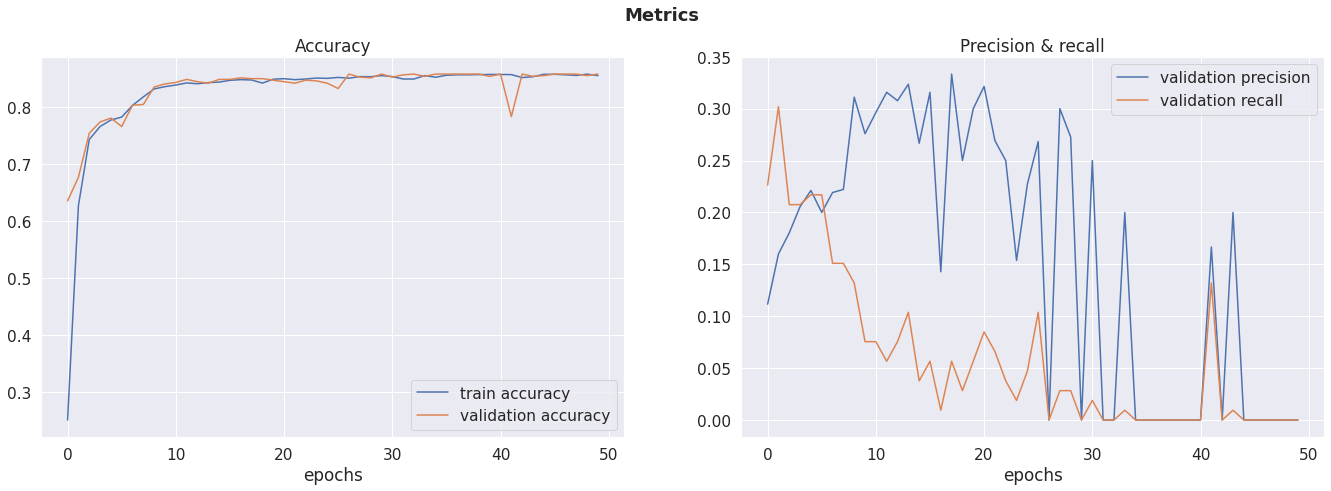

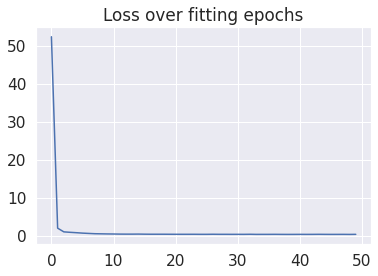

Min loss: 0.4214804470539093


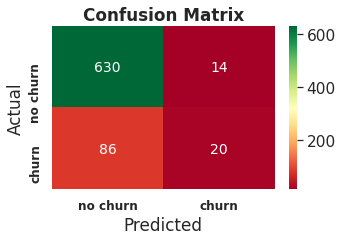


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 128, 8, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)     

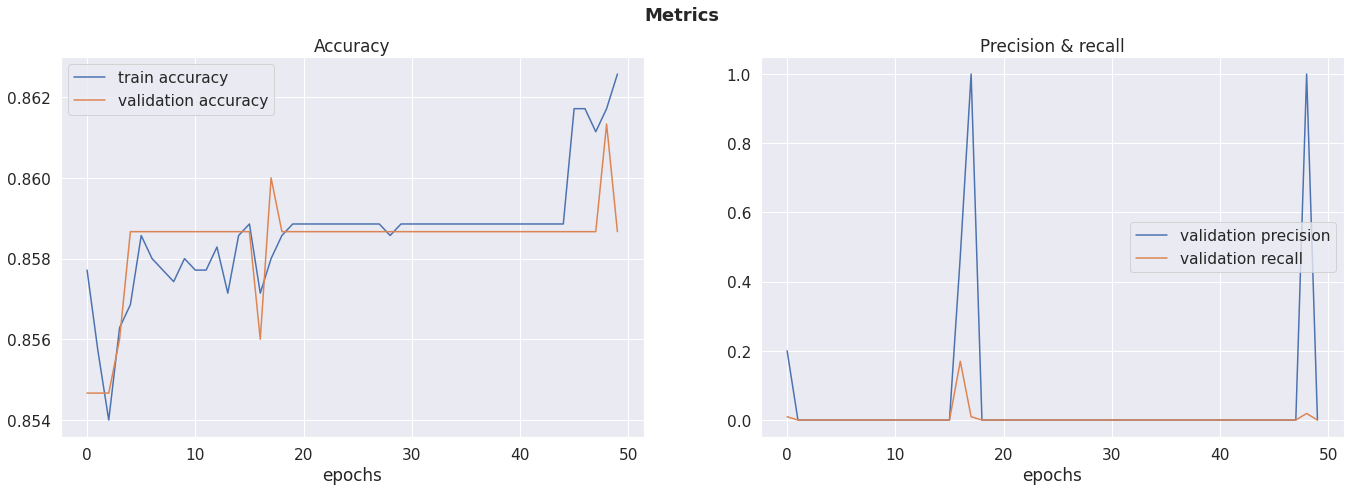

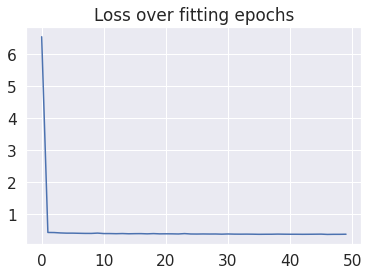

Min loss: 0.3764033317565918


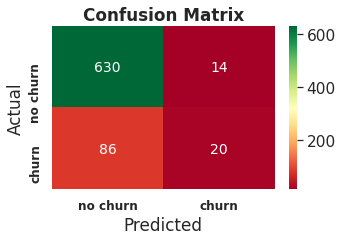


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 64, 16, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 16) 

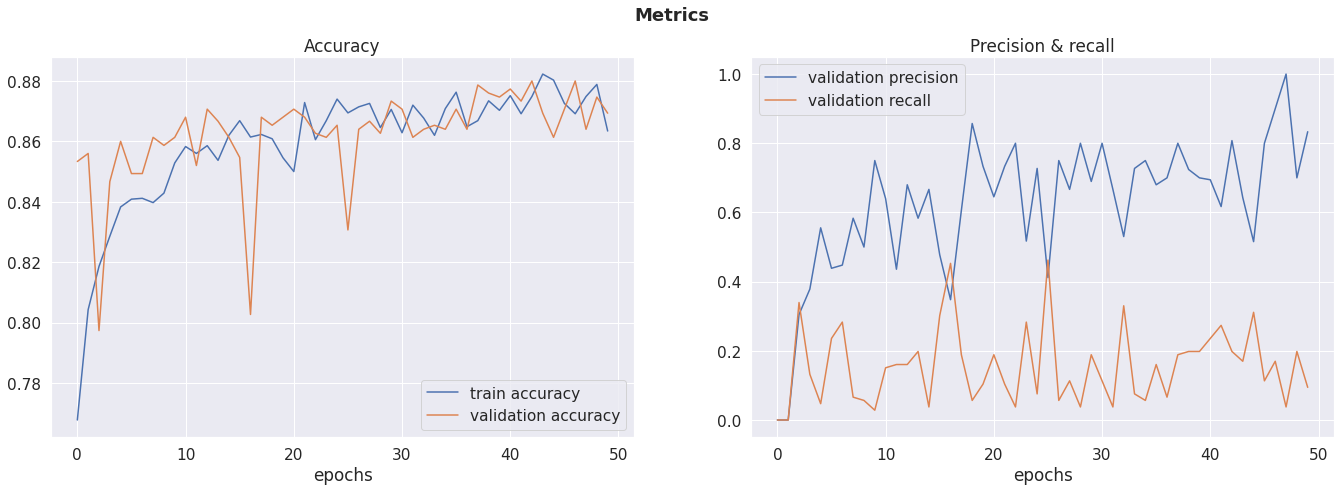

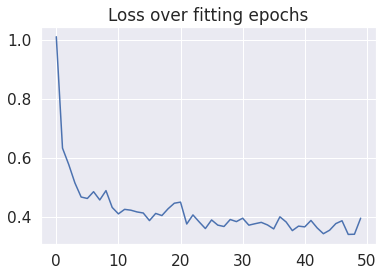

Min loss: 0.34104451537132263


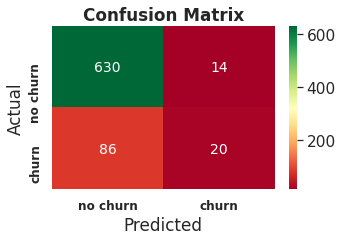


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 16, 64, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                528       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64)   

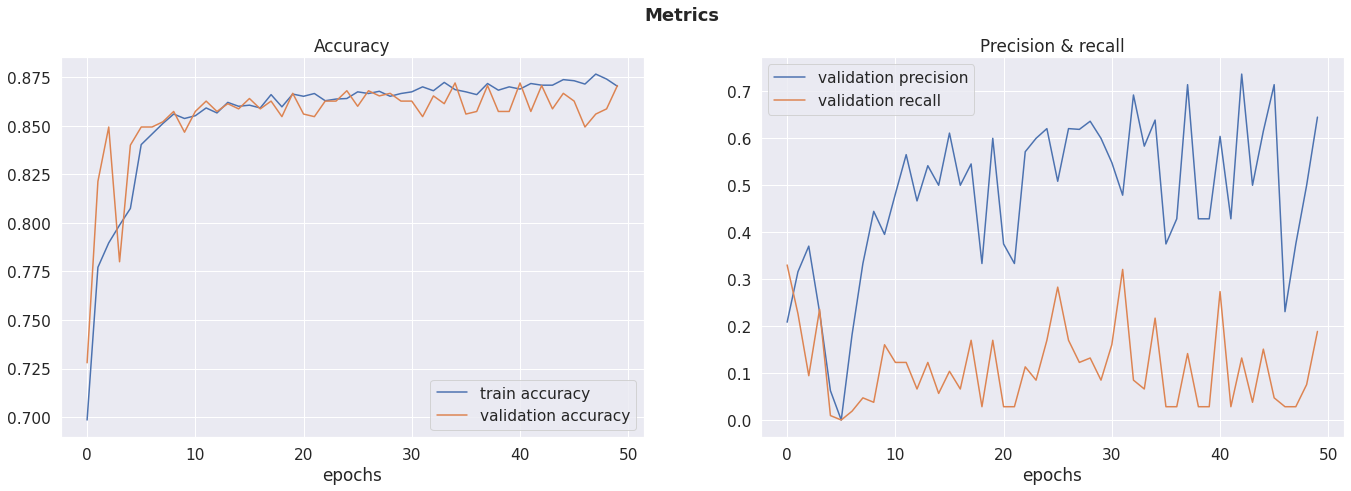

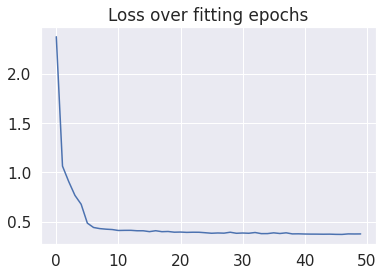

Min loss: 0.3709239363670349


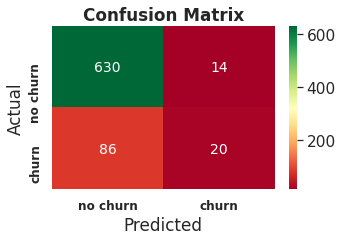


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 16, 16, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                144       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 16)    

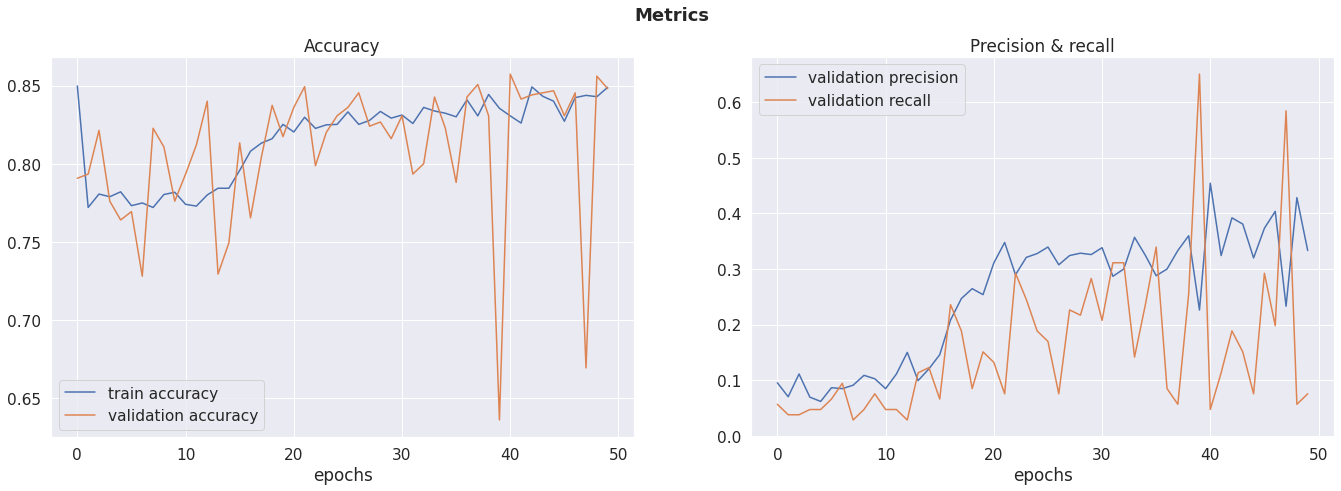

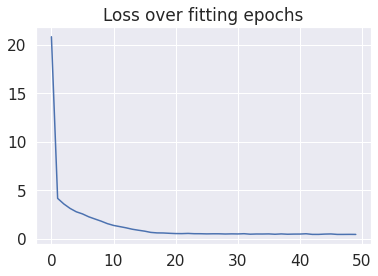

Min loss: 0.4597141444683075


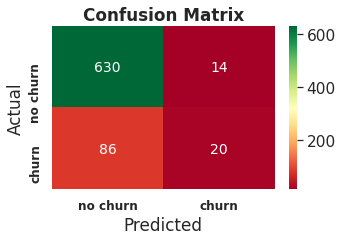


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 128, 16, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               2176      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 16)  

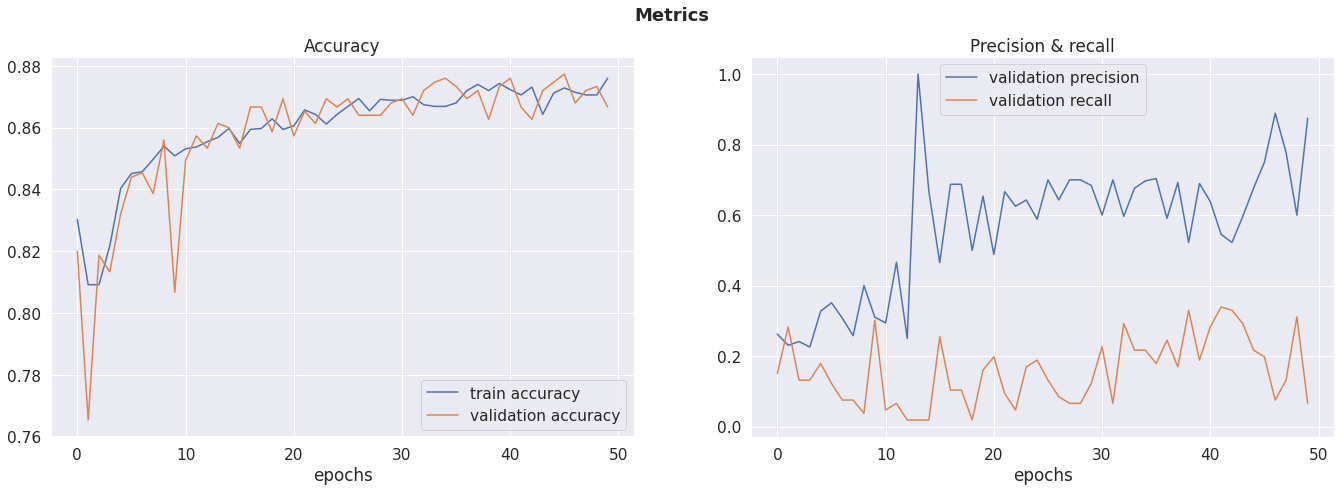

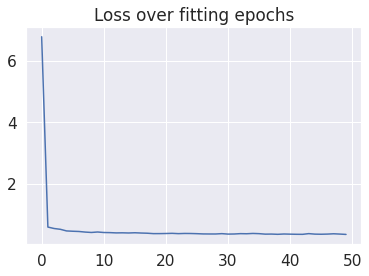

Min loss: 0.35988497734069824


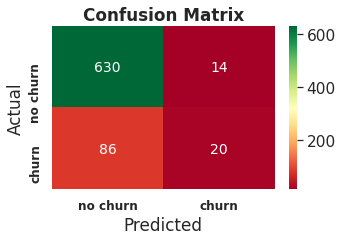


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 32, 32, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                288       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 32)    

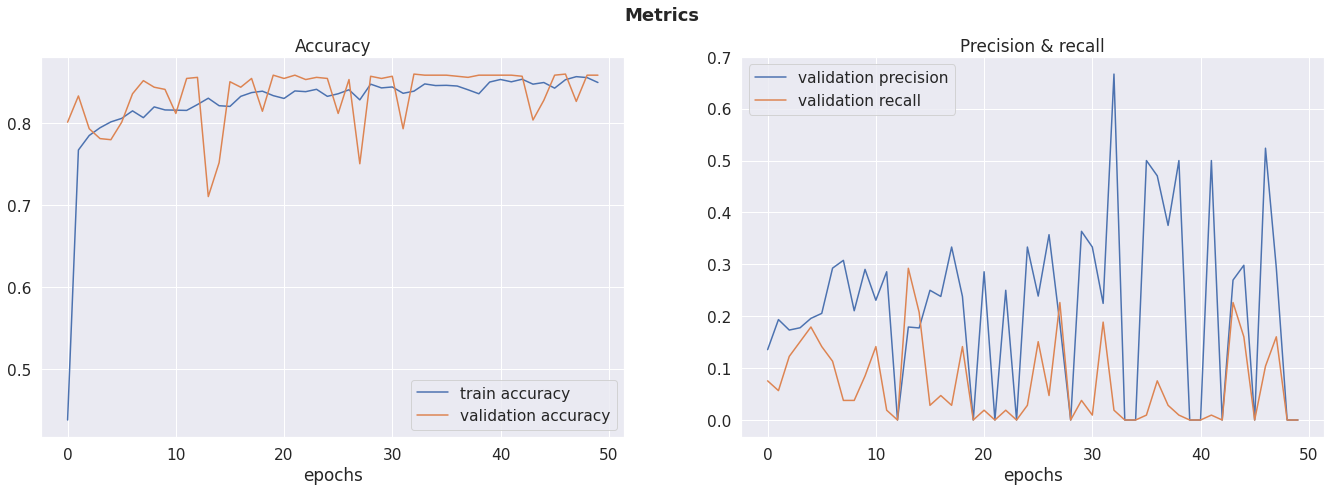

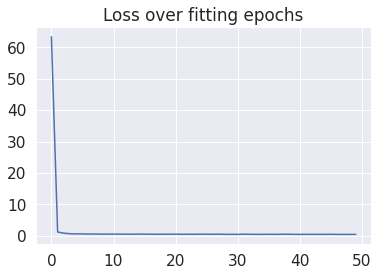

Min loss: 0.4171043038368225


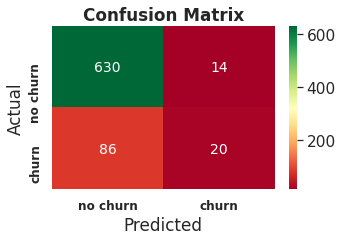


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 16, 128, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                1040      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 128) 

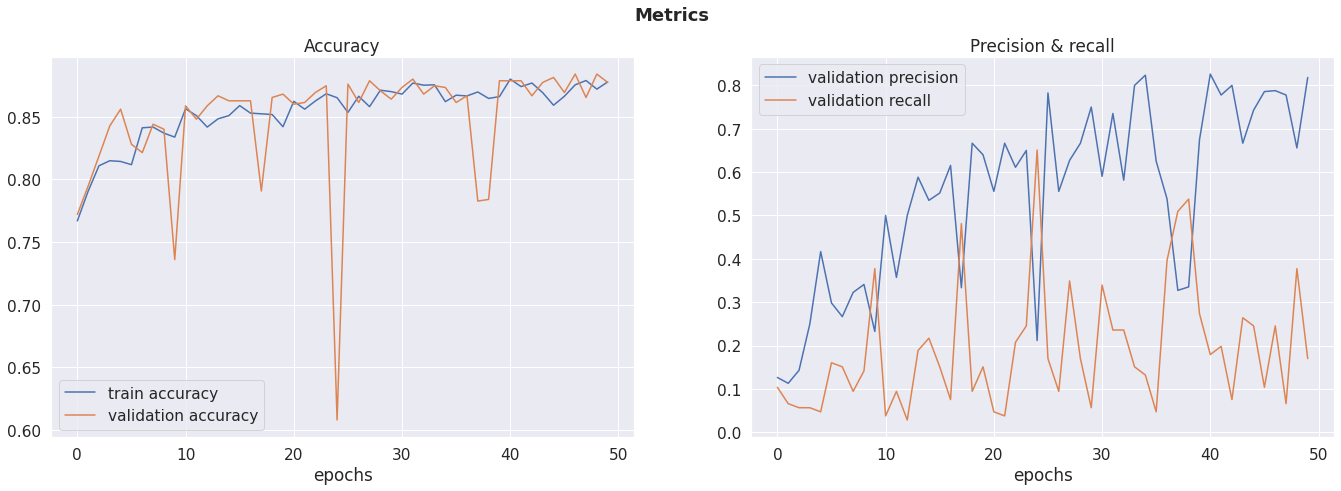

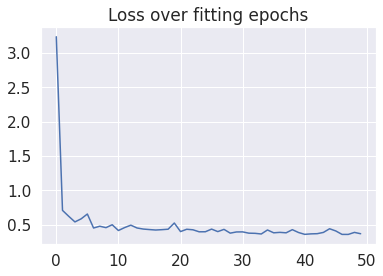

Min loss: 0.3570355474948883


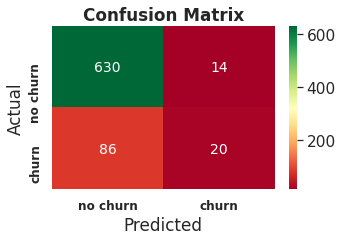


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 32, 64, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                544       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64)   

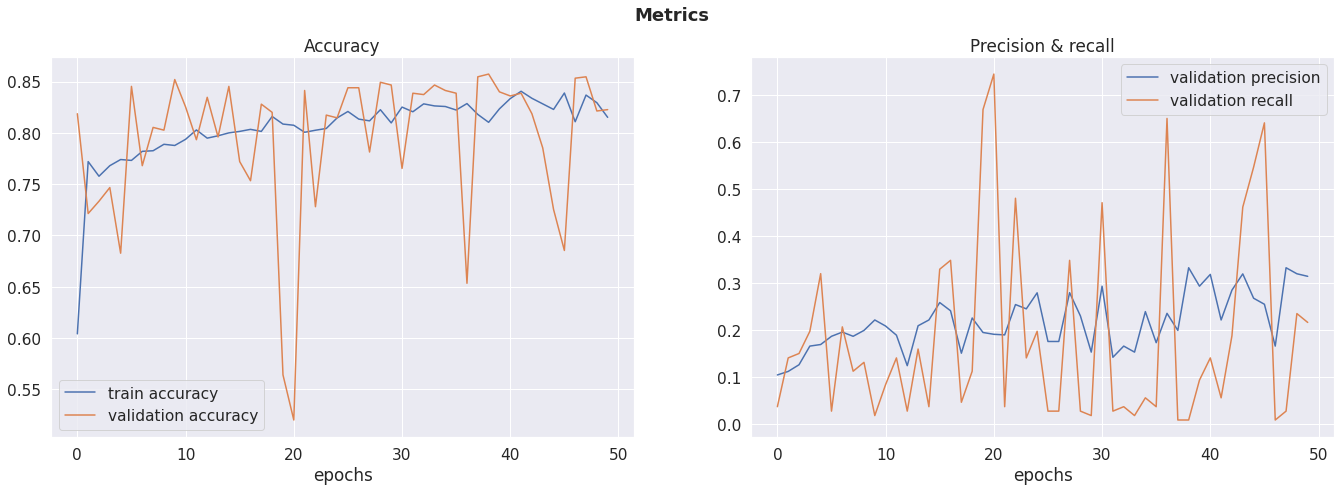

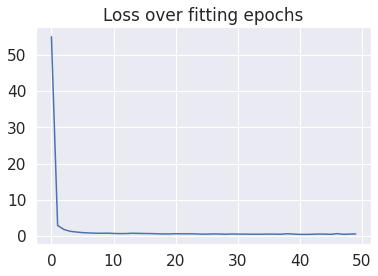

Min loss: 0.46109336614608765


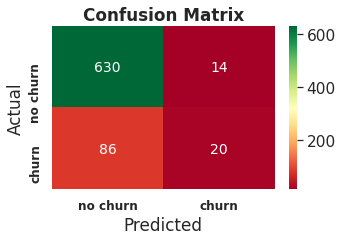


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 128, 32, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               1152      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 32)   

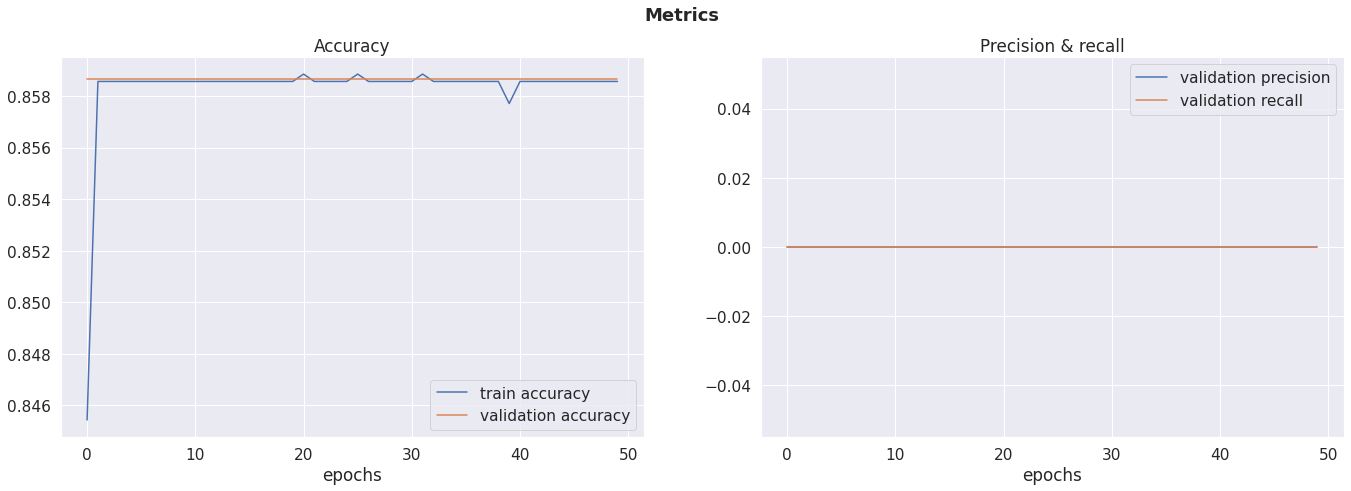

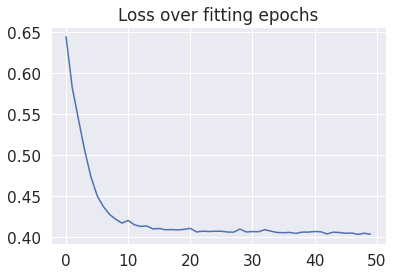

Min loss: 0.40375620126724243


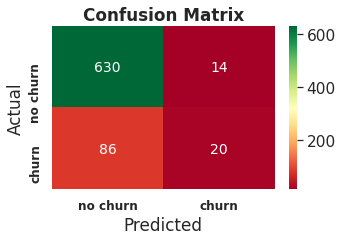


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 16, 64, 32, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                144       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64

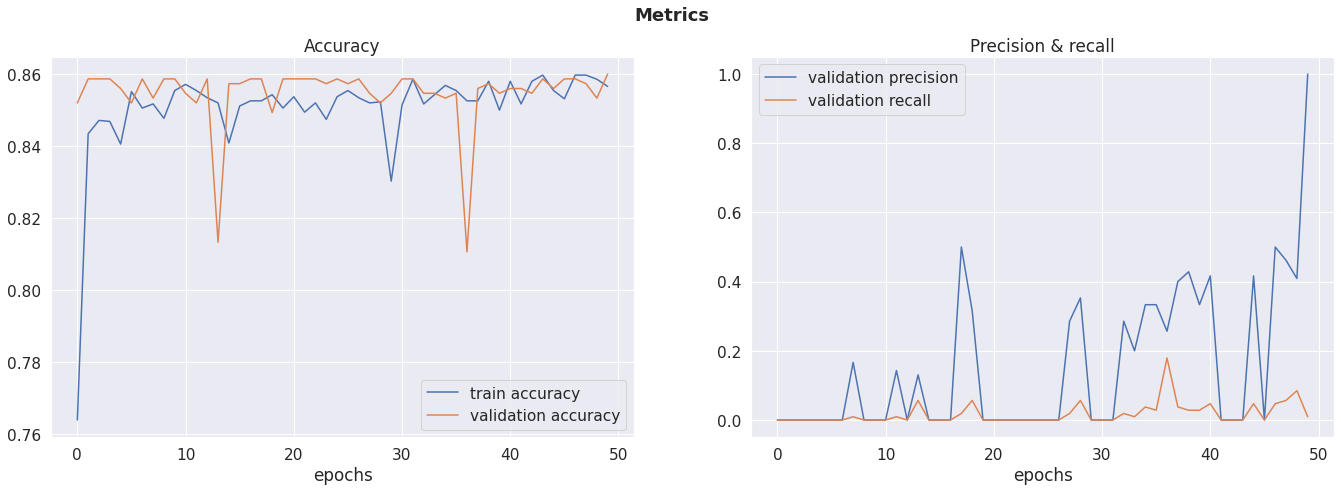

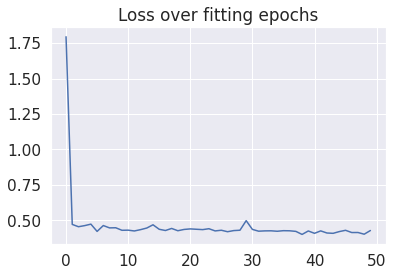

Min loss: 0.39973390102386475


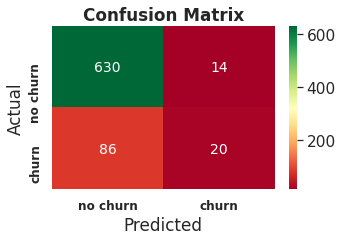


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 64, 32, 128, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 3

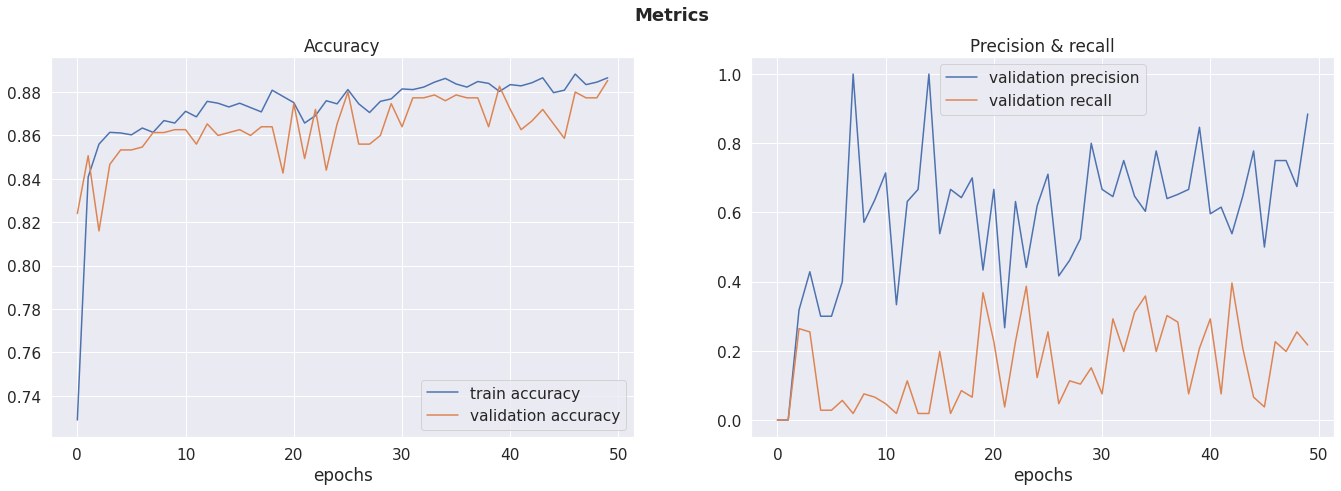

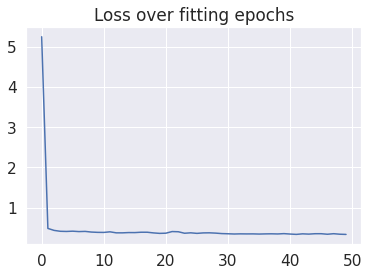

Min loss: 0.33031269907951355


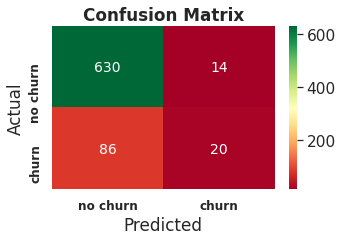


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 32, 32, 64, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                2080      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 32

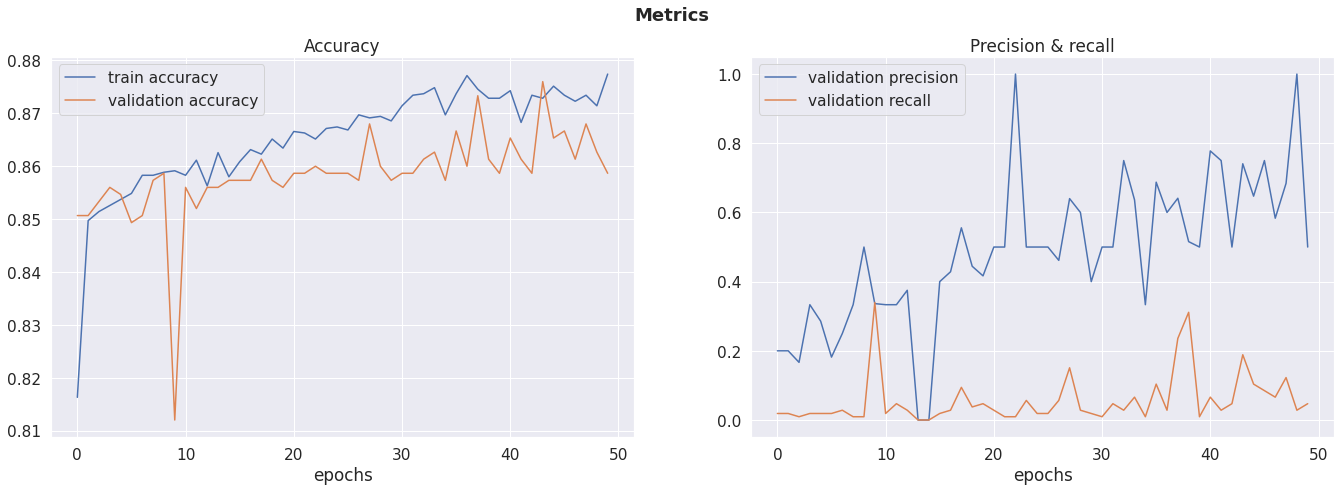

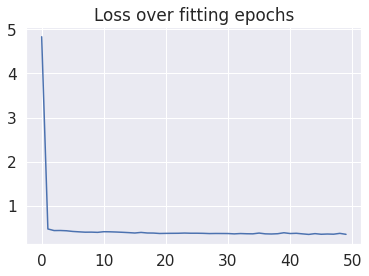

Min loss: 0.35610467195510864


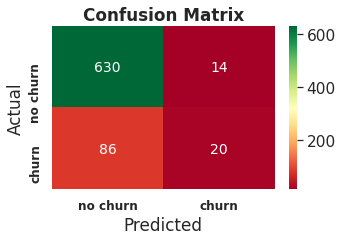


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 8, 16, 128, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 1032      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 

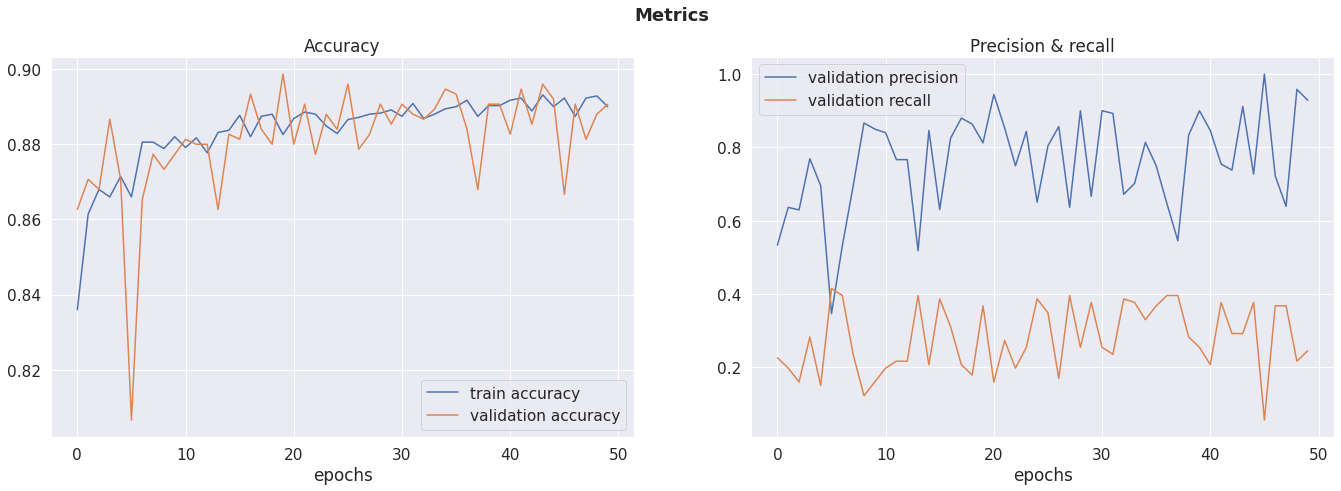

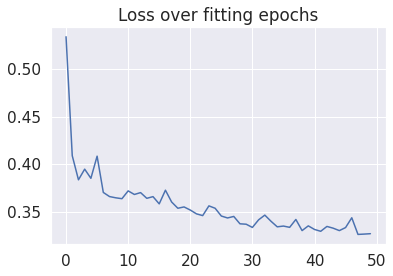

Min loss: 0.32626616954803467


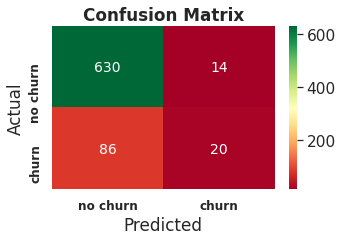


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 64, 16, 32, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                2112      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 16

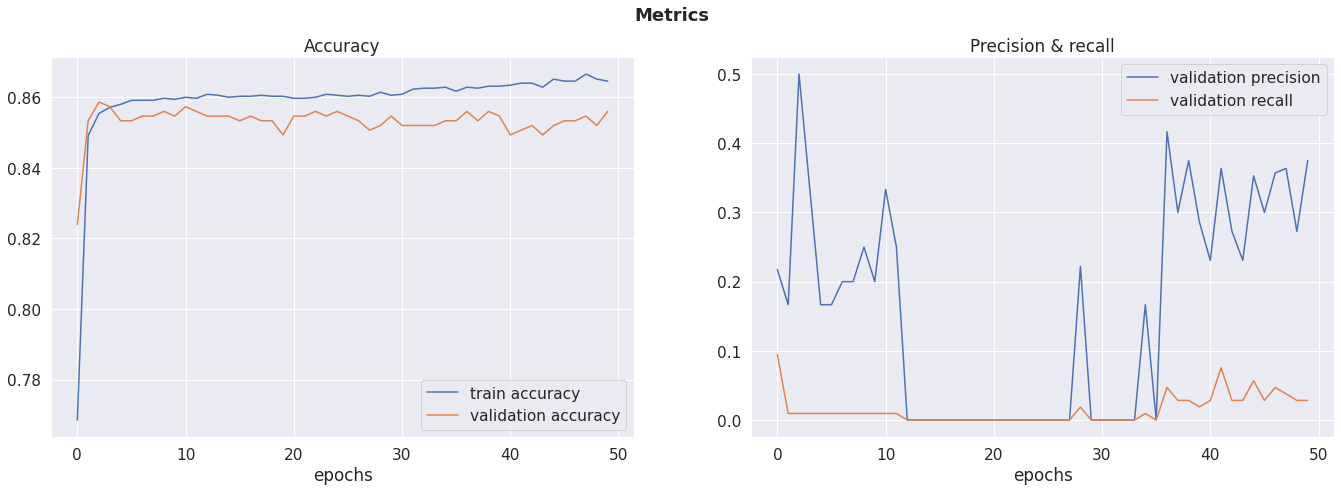

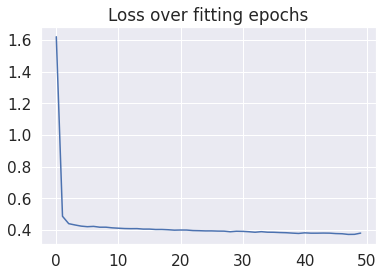

Min loss: 0.37315914034843445


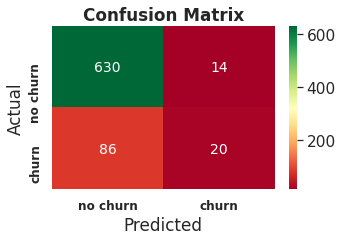


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 64, 8, 8, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                576       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)   

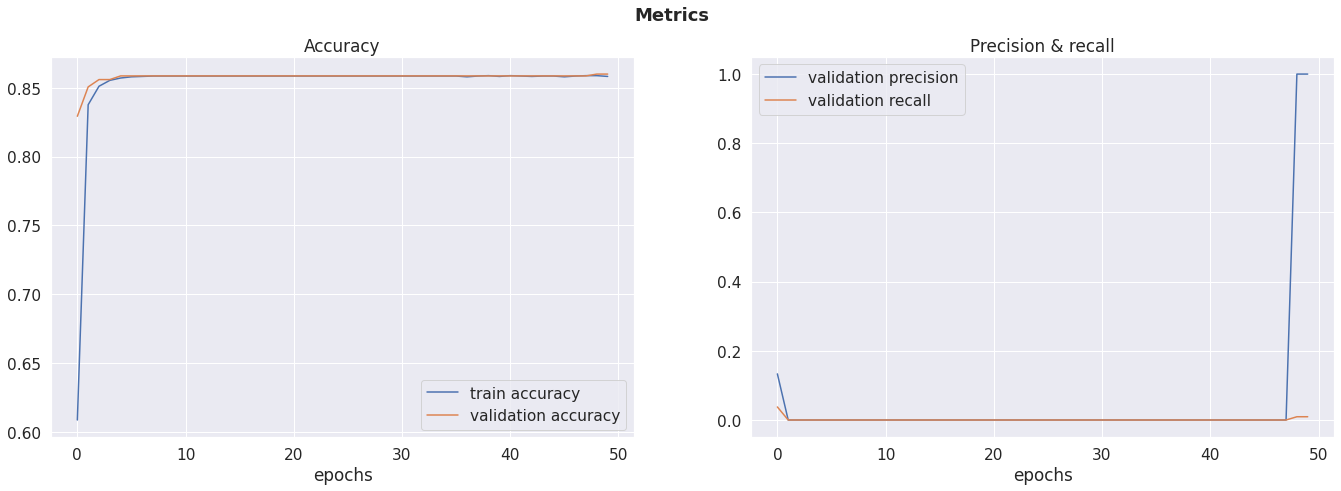

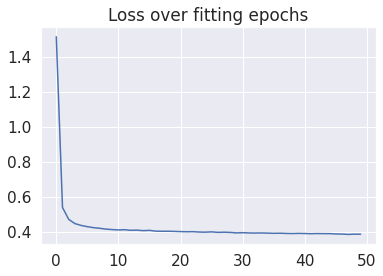

Min loss: 0.38707053661346436


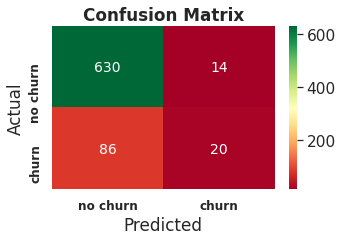


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 128, 128, 8, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               1152      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 12

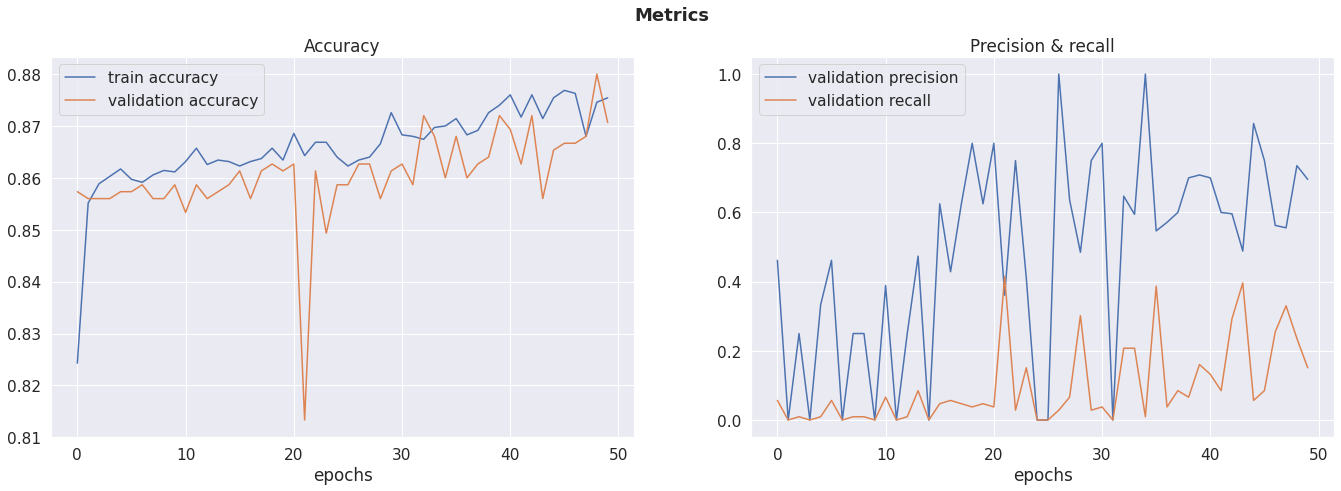

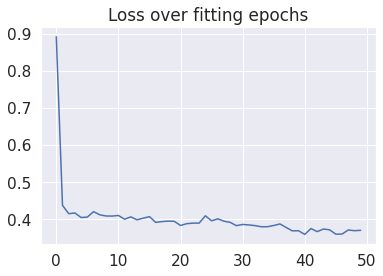

Min loss: 0.359080046415329


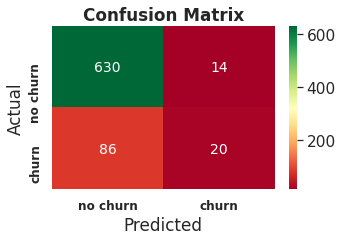


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 64, 8, 64, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                4160      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)  

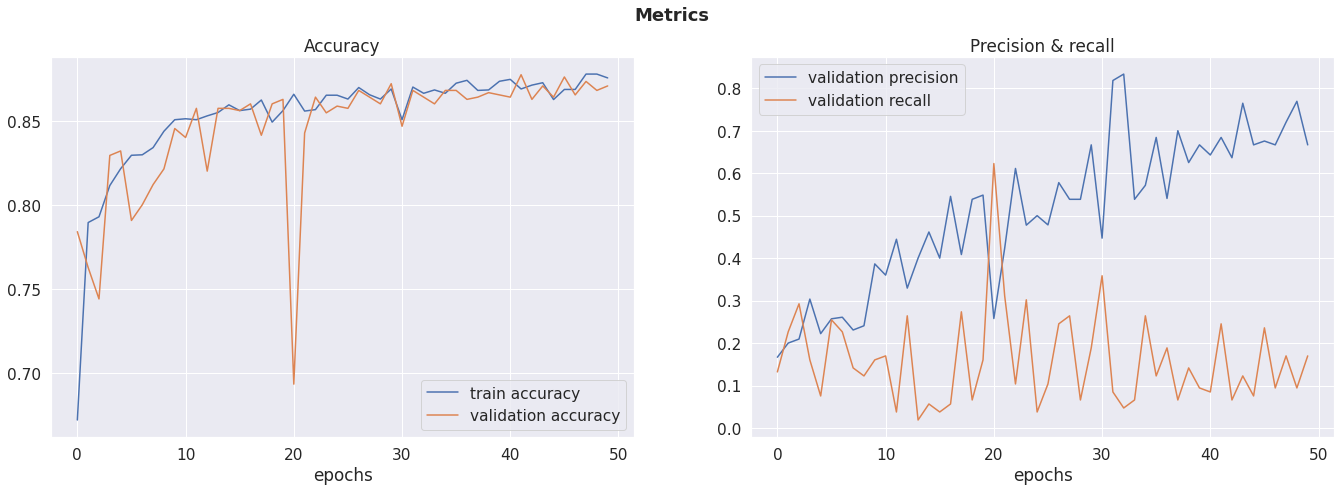

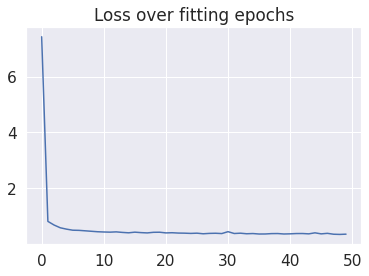

Min loss: 0.3544120490550995


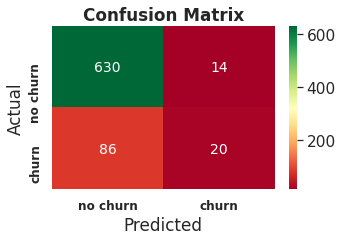


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 64, 64, 8, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64

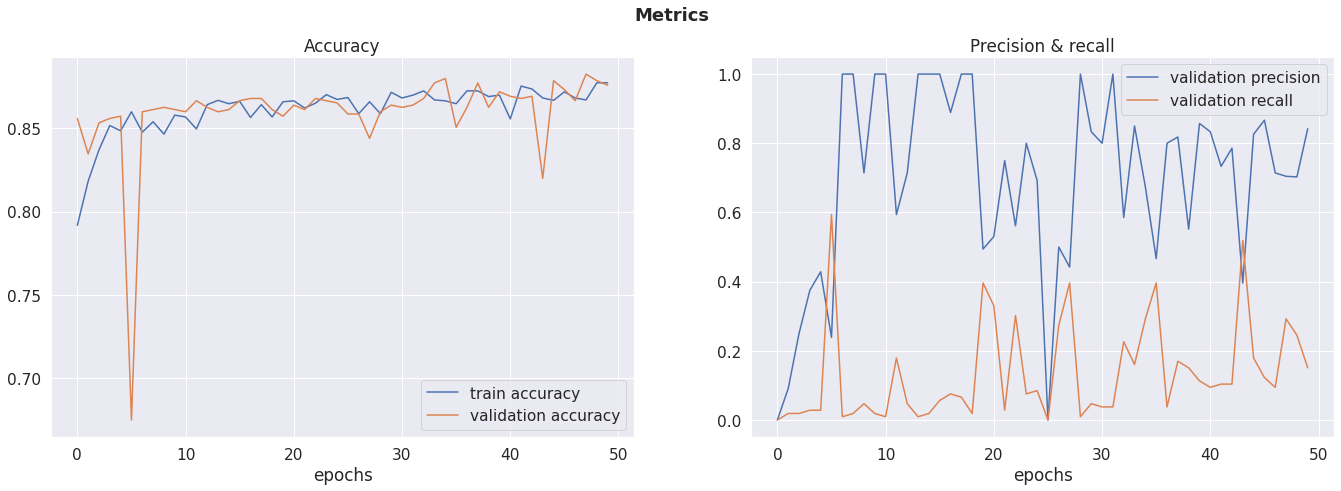

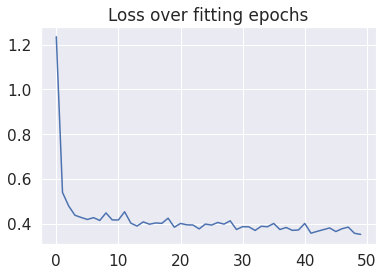

Min loss: 0.3521770238876343


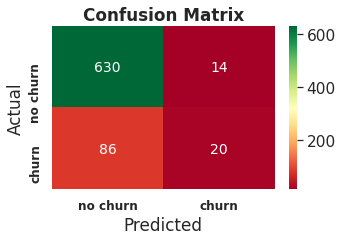


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 16, 32, 16, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                272       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 32

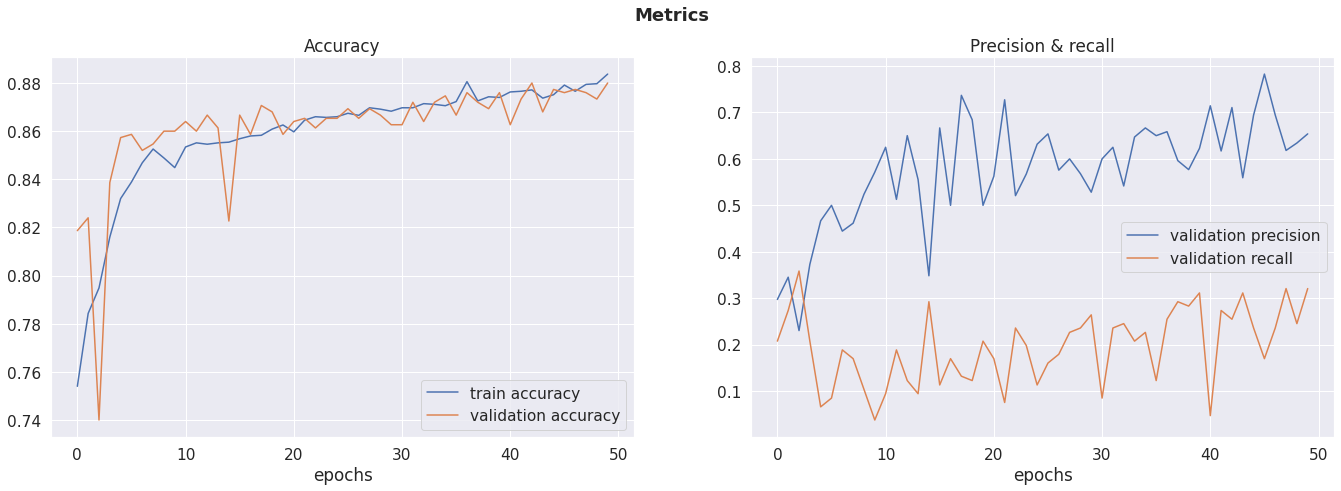

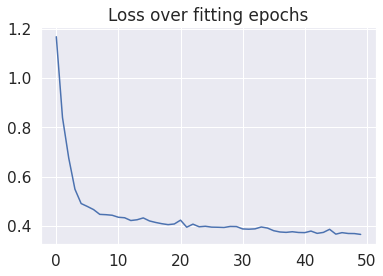

Min loss: 0.3646875321865082


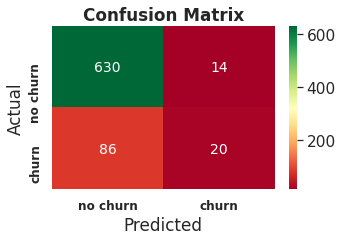


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       644
           1       0.59      0.19      0.29       106

    accuracy                           0.87       750
   macro avg       0.73      0.58      0.61       750
weighted avg       0.84      0.87      0.84       750



In [26]:
epochs = 50

scores_hidden_dict = dict()

for hidden_shape in test_comb:
    print(" === Hidden layer size:", hidden_shape, "===\n")

    scores = list()
    optimizer= Adam(0.0001)

    model_hidden = build_model(input_shape=20, hidden_shapes=hidden_shape, hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')
    model_hidden.summary()

    CB_checkpoint = ModelCheckpoint(monitor='val_recall', filepath='multi_lay_rec_model.hdf5', save_weights_only=True, save_best_only=True, mode='max', verbose=0)
    
    hist = model_hidden.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), verbose=0, callbacks=[CB_checkpoint])
    
    model_hidden.load_weights('multi_lay_rec_model.hdf5')
    #scores_hidden_dict[hidden_shape] = hist.history['accuracy']
    
    y_pred = model_pre.predict(x_test)
    threshold = 0.5
    y_pred = np.where(y_pred<=threshold, 0, 1)
    
    plot_learning_curves(hist)
    plot_learning_loss(hist)
    
    plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
    print_classification_report(y_test, y_pred)
    del model_hidden